In [1]:
!pip install pandas scikit-learn matplotlib seaborn
!pip install openpyxl
!pip install pandas scipy
!pip install umap-learn
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel, ttest_ind
import umap
import matplotlib.cm as cm
import statistics
import numpy as np
from collections import Counter
from scipy.stats import levene
import matplotlib.patches as patches
from scipy.stats import gaussian_kde
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import colorsys
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.stats.multitest import multipletests

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
  Using cached umap_learn-0.5.7-py3-none-any.whl (88 kB)
  Using cached numba-0.60.0-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.7 MB)
  Using cached pynndescent-0.5.13-py3-none-any.whl (56 kB)
  Using cached llvmlite-0.43.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (43.9 MB)


/srv/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


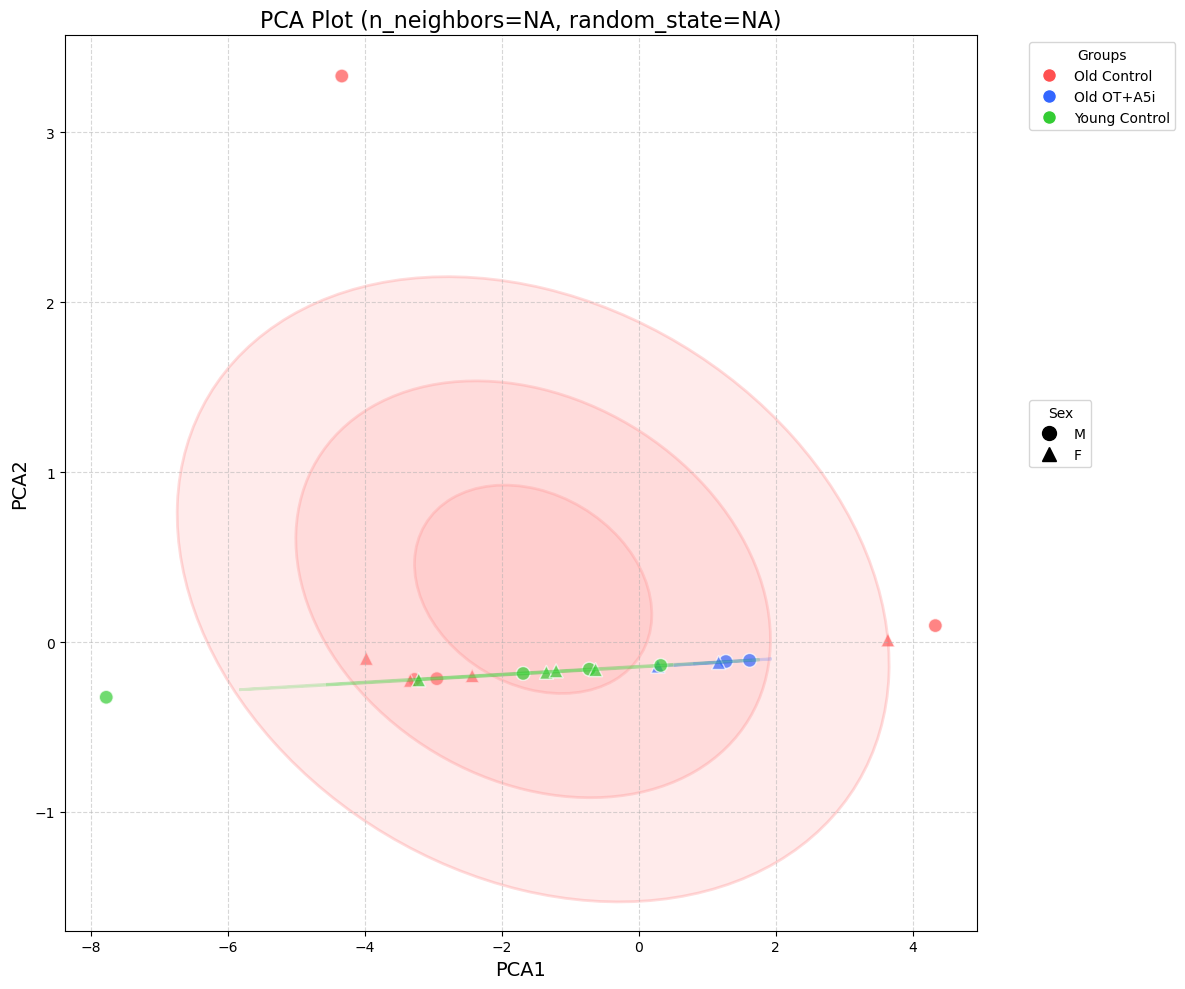

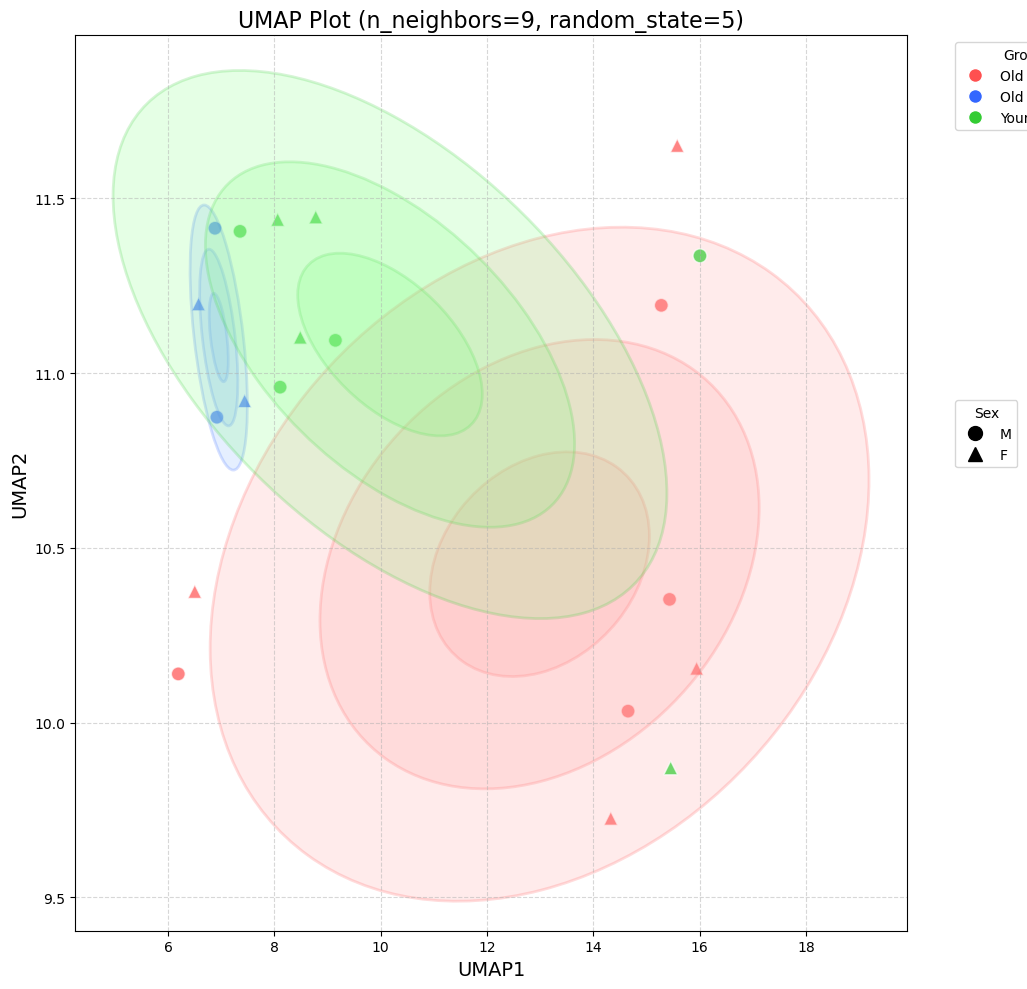

print to copy
Detected PCA Outliers:   SampleID Treatment Age Sex           Group    Color     Group_Desc Shape  \
4     YC_M         C   Y   M  (C, Y, (M, F))  #33cc33  Young Control     o   
7     OC_M         C   O   M  (C, O, (M, F))  #ff5050    Old Control     o   
9     OA_F         E   O   F  (E, O, (M, F))  #3366ff     Old OT+A5i     ^   

       PCA1      PCA2      UMAP1      UMAP2  PCA_Outlier  
4 -7.773978 -0.325089  16.007591  11.335788           -1  
7 -4.334753  3.330574  15.280415  11.194107           -1  
9  0.280185 -0.142326   7.440193  10.921154           -1  


In [31]:
# PCA for distinguishing males and females
#file_path = '11.12.24 PCA_No_Outliers.xlsx'
file_path = '10.25.24_Serum_ANL+AHA_Comb+Sex.xlsx'
df = pd.read_excel(file_path, header=None)
rand_state = 5
n_nbrs = 9
ellipses = True
outlier_fraction = 0.01
outlier_nbrs= 2

# Custom group definitions with color codes
# Replacing lists with tuples to make them hashable
group_info = {
#    ('C', 'OE', ('M', 'F')): ['#ff66cc', 'Treadmill Old Control ANL'],    # Bright Pink
    ('C', 'O', ('M', 'F')): ['#ff5050', 'Old Control'],              # Bright Red
#    ('E', 'OE', ('M', 'F')): ['#66ccff', 'Treadmill Old OT+A5i ANL'],    # Light Blue
    ('E', 'O', ('M', 'F')): ['#3366ff', 'Old OT+A5i'],              # Strong Blue
    ('C', 'Y', ('M', 'F')): ['#33cc33', 'Young Control'],            # Bright Green
#    ('C', 'O_ANL', ('M', 'F')): ['purple', 'Old Control ANL'],              # Bright Red
#    ('C', 'Y_ANL', ('M', 'F')): ['orange', 'Young Control ANL'],            # Bright Green
}


# Data preparation
sample_ids = df.iloc[0, 1:]
treatments = df.iloc[1, 1:]
ages = df.iloc[2, 1:]
sexes = df.iloc[3, 1:]
proteins = df.iloc[4:, 0]
expression_data = df.iloc[4:, 1:].T
expression_data.columns = proteins
expression_data.index = sample_ids

# Create a DataFrame for metadata
metadata = pd.DataFrame({
    'SampleID': sample_ids,
    'Treatment': treatments,
    'Age': ages,
    'Sex': sexes
})

# Retrieve unique values for each category
unique_treatments = metadata['Treatment'].unique().tolist()
unique_ages = metadata['Age'].unique().tolist()
unique_sexes = metadata['Sex'].unique().tolist()

# Function to determine group based on group_info keys
def assign_group(row, group_info):
    for key in group_info.keys():
        treat_key, age_key, sex_key = key
        
        # Treatment match: single value or tuple
        if isinstance(treat_key, tuple):
            treat_match = row['Treatment'] in treat_key
        else:
            treat_match = row['Treatment'] == treat_key
        
        # Age match: single value or tuple
        if isinstance(age_key, tuple):
            age_match = row['Age'] in age_key
        else:
            age_match = row['Age'] == age_key
        
        # Sex match: single value or tuple
        if isinstance(sex_key, tuple):
            sex_match = row['Sex'] in sex_key
        else:
            sex_match = row['Sex'] == sex_key
        
        if treat_match and age_match and sex_match:
            return key
    return 'Unassigned'  # Assign to 'Unassigned' if no group matches

# Assign groups to each sample
metadata['Group'] = metadata.apply(lambda row: assign_group(row, group_info), axis=1)

# Assign colors based on group_info
metadata['Color'] = metadata['Group'].apply(lambda x: group_info[x][0] if x in group_info else 'grey')  # Default to grey for 'Unassigned'
metadata['Group_Desc'] = metadata['Group'].apply(lambda x: group_info[x][1] if x in group_info else 'Unassigned')

# Assign shapes based on Sex
# 'M' -> circle, 'F' -> triangle
shape_dict = {'M': 'o', 'F': '^'}
metadata['Shape'] = metadata['Sex'].map(shape_dict)

# ---------------------------
# Dimensionality Reduction
# ---------------------------

# Perform PCA
pca = PCA(n_components=2, random_state=rand_state)
pca_result = pca.fit_transform(expression_data)
metadata['PCA1'] = pca_result[:, 0]
metadata['PCA2'] = pca_result[:, 1]

# Perform UMAP
reducer = umap.UMAP(n_neighbors=n_nbrs, random_state=rand_state)
umap_result = reducer.fit_transform(expression_data)
metadata['UMAP1'] = umap_result[:, 0]
metadata['UMAP2'] = umap_result[:, 1]

# ---------------------------
# Ellipse Drawing Function
# ---------------------------

def draw_confidence_ellipses(x, y, ax, n_stds=[0.5, 1.0, 1.5], alpha=0.2, linewidth=2, **kwargs):
    """
    Draw multiple confidence ellipses based on specified standard deviations.
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    # Calculate mean and covariance
    mean_x, mean_y = np.mean(x), np.mean(y)
    cov = np.cov(x, y)
    
    # Eigen decomposition
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    
    # Calculate angle of ellipse
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
    # Iterate over the desired number of standard deviations
    for i, n_std in enumerate(n_stds):
        # Width and height of ellipse
        width, height = 2 * n_std * np.sqrt(vals)
        
        # Create progressively lighter colors
        base_color = kwargs.get('base_color', 'black')
        color = mcolors.to_rgba(base_color)
        # Adjust the lightness by mixing with white
        fill_color = tuple([min(1, c + 0.3) for c in color[:3]]) + (alpha,)
        
        # Create and add the ellipse
        ellipse = Ellipse((mean_x, mean_y), width=width, height=height,
                          angle=theta, edgecolor=base_color, facecolor=fill_color,
                          linewidth=linewidth, alpha=alpha)
        ax.add_patch(ellipse)
#matplotlib confidence ellipse from: https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)
# ---------------------------
# Scatter Plotting Function
# ---------------------------

def create_scatter_plot(metadata, x_col, y_col, title, add_ellipses=False):
    # Increase figure size to make room for legends on the right
    plt.figure(figsize=(14, 10))
    ax = plt.gca()

    # Filter out 'Unassigned' samples if they exist
    plot_data = metadata[metadata['Group'] != 'Unassigned']
    
    # Create legend handles for groups
    group_legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=group_info[key][1],
               markerfacecolor=group_info[key][0], markersize=10)
        for key in group_info.keys()
    ]
    
    # Create legend handles for shapes
    shape_legend_elements = [
        Line2D([0], [0], marker=shape, color='k', label=sex,
               linestyle='None', markersize=10)
        for sex, shape in shape_dict.items()
    ]
    
    # Plot each group and sex
    for key in group_info.keys():
        group_data = plot_data[plot_data['Group'] == key]
        if group_data.empty:
            continue  # Skip if no data in group
        
        # Iterate through each sex within the group
        for sex, shape in shape_dict.items():
            subset = group_data[group_data['Sex'] == sex]
            if subset.empty:
                continue  # Skip if no samples for this sex in the group
            
            # Plot the subset with the group's color and the sex's marker
            plt.scatter(subset[x_col], subset[y_col],
                        c=subset['Color'],
                        marker=shape,
                        label=f"{group_info[key][1]} - {sex}",
                        edgecolor='w',
                        alpha=0.7,
                        s=100)
        
        # Draw confidence ellipses if required and if plotting UMAP
        if add_ellipses:
            # Extract all samples in the group for ellipse plotting
            x = group_data[x_col].values
            y = group_data[y_col].values
            draw_confidence_ellipses(x, y, ax, n_stds=[0.5, 1.0, 1.5], 
                                     base_color=group_info[key][0],
                                     alpha=0.2,
                                     linewidth=2)
#            confidence_ellipse(x, y, ax, n_std = 0.5, edgecolor='red')
    # Customize plot
    plt.title(title, fontsize=16)
    plt.xlabel(x_col, fontsize=14)
    plt.ylabel(y_col, fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Combine legends and position them to the right
    first_legend = plt.legend(handles=group_legend_elements, title='Groups', loc='upper left', bbox_to_anchor=(1.05, 1))
#    first_legend = plt.legend(handles=group_legend_elements, title='Groups')
#    second_legend = plt.legend(handles=shape_legend_elements, title='Sex')
    second_legend = plt.legend(handles=shape_legend_elements, title='Sex', loc='upper left', bbox_to_anchor=(1.05, 0.6))
    plt.gca().add_artist(first_legend)  # Add the first legend manually to avoid it being overwritten
    
    # Adjust layout to make room for legends
    # Dynamically adjust 'rect' based on whether it's PCA or UMAP
    if 'UMAP' in title:
        plt.tight_layout(rect=[0, 0, 0.75, 1])  # More space for legends
    else:
        plt.tight_layout(rect=[0, 0, 0.8, 1])   # Slightly more space
    
    plt.show()
# Define plot titles with n_nbrs and rand_state
pca_title = 'PCA Plot (n_neighbors=NA, random_state=NA)'  # PCA doesn't use n_neighbors
umap_title = f'UMAP Plot (n_neighbors={n_nbrs}, random_state={rand_state})'

# Create PCA plot without ellipses
create_scatter_plot(metadata, 'PCA1', 'PCA2', pca_title, add_ellipses=ellipses)

# Create UMAP plot with confidence ellipses
create_scatter_plot(metadata, 'UMAP1', 'UMAP2', umap_title, add_ellipses=ellipses)

print('print to copy')

# Detect outliers within each group
metadata['PCA_Outlier'] = 1  # Default all samples as inliers initially

# Loop through each group in group_info and apply LocalOutlierFactor
for group_key, (color, group_name) in group_info.items():
    group_condition = (
        (metadata['Treatment'] == group_key[0]) &
        (metadata['Age'] == group_key[1])
    )
    
    # Select subset of data for this group
    group_data = metadata.loc[group_condition, ['PCA1', 'PCA2']]
    
    if not group_data.empty:
        # Apply Local Outlier Factor to detect outliers in the group
        lof = LocalOutlierFactor(contamination=outlier_fraction, n_neighbors=outlier_nbrs)
        outlier_labels = lof.fit_predict(group_data)
        # Update 'Outlier' column based on outlier detection
        metadata.loc[group_condition, 'PCA_Outlier'] = outlier_labels
outliers = metadata[metadata['PCA_Outlier'] == -1]
print("Detected PCA Outliers:",outliers)

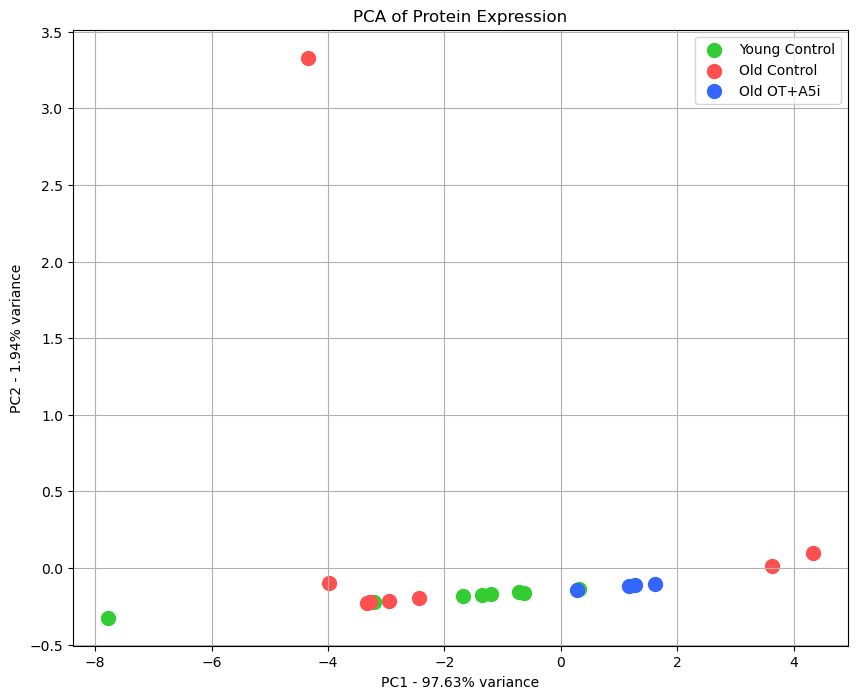

/srv/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Detected Outliers:       UMAP1     UMAP2 Treatment Age Sex SampleID  Outlier
1  3.083210 -5.874311         C   Y   B     YC_F       -1
3  2.949116 -7.155158         C   Y   B     YC_M       -1
4 -7.860387 -2.410744         C   O   B     OC_F       -1
7 -7.559807 -2.176131         C   O   B     OC_M       -1
9 -8.197417 -3.047111         E   O   B     OA_F       -1


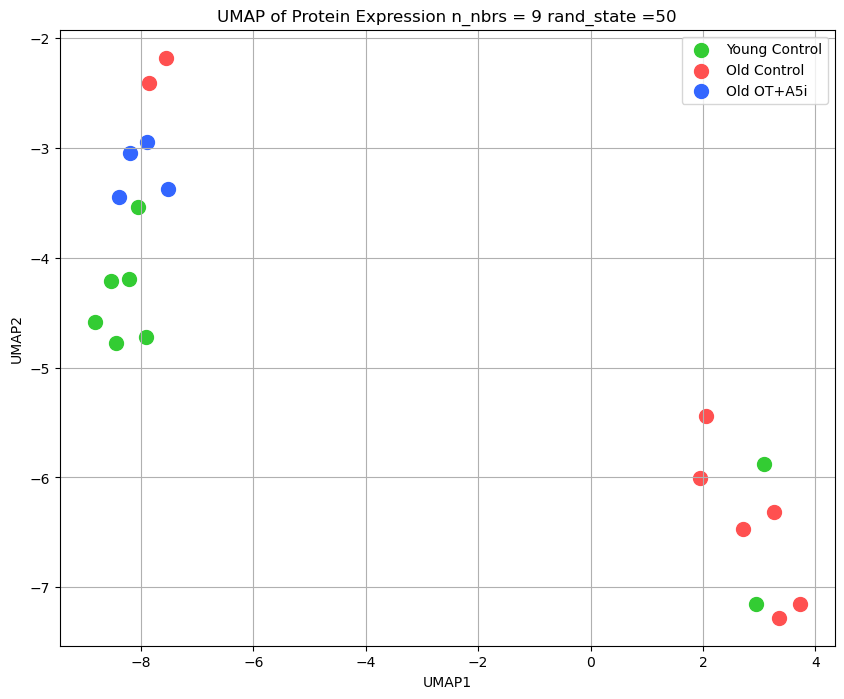

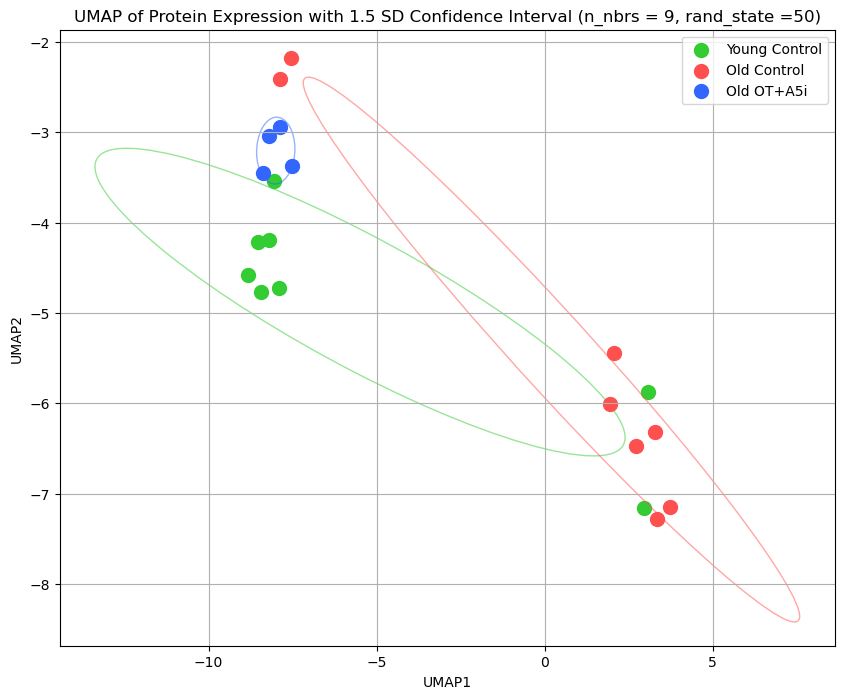

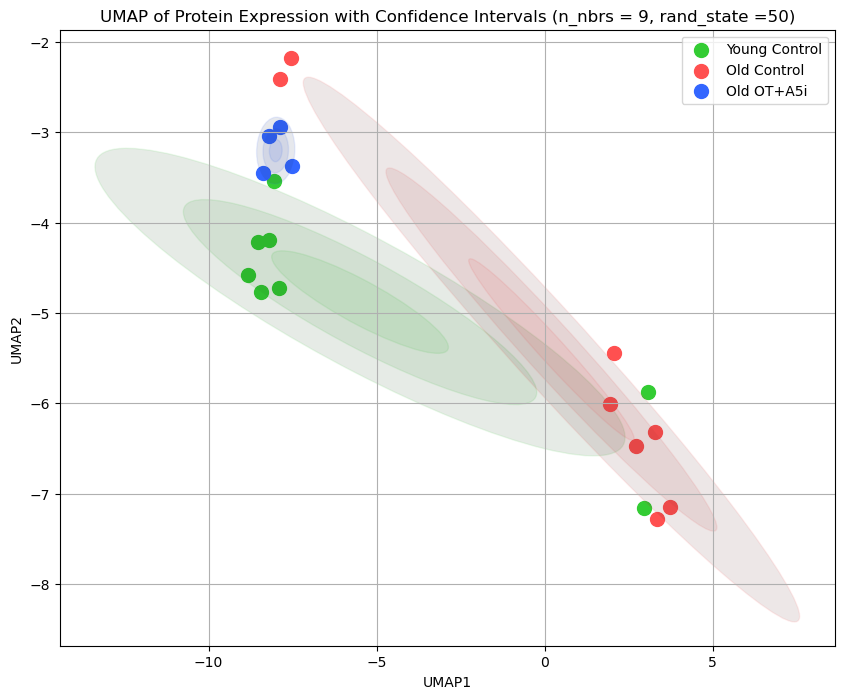

print to copy


In [18]:
# Load the Excel sheet (replace 'Proteomics Mod.xlsx' with your actual file name)
#n_nbrs set to 15 by default
#Outlier_nbrs: 1) greater than the minimum number of samples a cluster has to contain, so that other samples can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by samples that can potentially be local outliers. 
file_path = '10.25.24_Serum_ANL+AHA_Comb.xlsx'
df = pd.read_excel(file_path, header=None)
rand_state = 50
n_nbrs = 9
manual_prot = False
manual_color = 1
outlier_fraction = 0.25
outlier_nbrs = 2
# ['Granzyme B', 'HVEM / TNFRSF14', 'TCA-3']

# Custom group definitions including color and label as a list
#group_info = {
#    ('C', 'OE', 'M'): ['#ff66cc', 'Male Treadmill Old Control'],  # Bright Pink
#    ('C', 'O', 'M'): ['#ff5050', 'Male Old Control'],  # Bright Red
#    ('E', 'OE', 'M'): ['#66ccff', 'Male Treadmill Old OT+A5i'],  # Light Blue
#    ('E', 'O', 'M'): ['#3366ff', 'Male Old OT+A5i'],  # Strong Blue
#    ('C', 'Y', 'M'): ['#33cc33', 'Male Young Control'],  # Bright Green
#    ('C', 'OE', 'F'): ['#ff9966', 'Female Treadmill Old Control'],  # Soft Orange
#    ('C', 'O', 'F'): ['#9933ff', 'Female Old Control'],  # Purple
#    ('E', 'OE', 'F'): ['#ffff66', 'Female Treadmill Old OT+A5i'],  # Bright Yellow
#    ('E', 'O', 'F'): ['#cc6600', 'Female Old OT+A5i'],  # Dark Brown/Orange
#    ('C', 'Y', 'F'): ['#009999', 'Female Young Control'],  # Dark Teal
#}

#Group info for sex combined
group_info = {
#    ('C', 'OE', 'B'): ['#ff66cc', 'Treadmill Old Control'],  # Bright Pink
    ('C', 'O', 'B'): ['#ff5050', 'Old Control'],  # Bright Red
#    ('E', 'OE', 'B'): ['#66ccff', 'Treadmill Old OT+A5i'],  # Light Blue
    ('E', 'O', 'B'): ['#3366ff', 'Old OT+A5i'],  # Strong Blue
    ('C', 'Y', 'B'): ['#33cc33', 'Young Control'],  # Bright Green
}

# Process the input data
# First row: Sample IDs
sample_ids = df.iloc[0, 1:]

# Second row: Treatment
treatments = df.iloc[1, 1:]

# Third row: Age
ages = df.iloc[2, 1:]

# Fourth row: Sex
sexes = df.iloc[3, 1:]

# Protein names (1st column)
proteins = df.iloc[4:, 0]

# Protein expression data (everything from row 5 onward, excluding the first column)
expression_data = df.iloc[4:, 1:].T
expression_data.columns = proteins  # Set protein names as column headers

# If specific proteins are selected, filter the data to only include them
if manual_prot:
    selected_proteins = manual_prot
    expression_data = expression_data[selected_proteins]
else:
    selected_proteins = proteins  # Use all proteins if no specific proteins are provided

# Perform PCA on the expression data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(expression_data)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Treatment'] = treatments.values
pca_df['Age'] = ages.values
pca_df['Sex'] = sexes.values
pca_df['SampleID'] = sample_ids.values

# Map color and label to the DataFrame
pca_df['Group'] = list(zip(pca_df['Treatment'], pca_df['Age'], pca_df['Sex']))

# If manual_color is 0, use an automatic color map, otherwise use group_info
if manual_color == 0:
    unique_groups = pca_df['Group'].unique()
    num_groups = len(unique_groups)
    colormap = plt.get_cmap('Viridis')
    colors = [colormap(i / num_groups) for i in range(num_groups)]
    
    # Create a dictionary that maps each group to a color
    auto_color_map = {group: color for group, color in zip(unique_groups, colors)}
    pca_df['Color'] = pca_df['Group'].map(auto_color_map)
    
else:
    # Safely map colors, if group not found in group_info, assign default color
    pca_df['Color'] = pca_df['Group'].map(lambda group: group_info.get(group, ['grey', 'Unknown'])[0])
pca_df['Label'] = pca_df['Group'].map(lambda group: group_info.get(group, ['grey', 'Unknown'])[1])

# Plot PCA result with custom colors and legend
plt.figure(figsize=(10, 8))

# Create the scatterplot with the custom colors
for group in pca_df['Group'].unique():
    group_data = pca_df[pca_df['Group'] == group]
    if group in group_info or manual_color == 0:
        plt.scatter(group_data['PC1'], group_data['PC2'], color=group_data['Color'].iloc[0], label=group_data['Label'].iloc[0], s=100)

# Customizing the plot
plt.title('PCA of Protein Expression')
plt.xlabel(f'PC1 - {pca.explained_variance_ratio_[0]:.2%} variance')
plt.ylabel(f'PC2 - {pca.explained_variance_ratio_[1]:.2%} variance')
plt.grid(True)

# Add custom legend
plt.legend(loc='best')
plt.show()

# Perform UMAP on the expression data
umap_model = umap.UMAP(n_neighbors=n_nbrs, min_dist=0.1, n_components=2, random_state=rand_state)
umap_result = umap_model.fit_transform(expression_data)

# Create a DataFrame with UMAP results
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'])
umap_df['Treatment'] = treatments.values
umap_df['Age'] = ages.values
umap_df['Sex'] = sexes.values
umap_df['SampleID'] = sample_ids.values

# Detect outliers within each group
umap_df['Outlier'] = 1  # Default all samples as inliers initially

# Loop through each group in group_info and apply LocalOutlierFactor
for group_key, (color, group_name) in group_info.items():
    group_condition = (
        (umap_df['Treatment'] == group_key[0]) &
        (umap_df['Age'] == group_key[1]) &
        (umap_df['Sex'] == group_key[2])
    )
    
    # Select subset of data for this group
    group_data = umap_df.loc[group_condition, ['UMAP1', 'UMAP2']]
    
    if not group_data.empty:
        # Apply Local Outlier Factor to detect outliers in the group
        lof = LocalOutlierFactor(contamination=outlier_fraction, n_neighbors=outlier_nbrs)
        outlier_labels = lof.fit_predict(group_data)
        # Update 'Outlier' column in umap_df based on outlier detection
        umap_df.loc[group_condition, 'Outlier'] = outlier_labels
outliers = umap_df[umap_df['Outlier'] == -1]
print("Detected Outliers:",outliers)
# Outliers are labeled as -1, inliers as 1
# Now, umap_df contains the UMAP coordinates, metadata, and outlier information

# Create the group tuples
umap_df['Group'] = list(zip(umap_df['Treatment'], umap_df['Age'], umap_df['Sex']))

# If manual_color is set to 0, automatically assign colors using a color map
if manual_color == 0:
    umap_df['Color'] = umap_df['Group'].map(auto_color_map)
else:
    # Map color and label to the DataFrame using group_info, assign 'grey' for missing groups
    umap_df['Color'] = umap_df['Group'].map(lambda group: group_info.get(group, ['grey', 'Unknown'])[0])

# Safely map labels
umap_df['Label'] = umap_df['Group'].map(lambda group: group_info.get(group, ['grey', 'Unknown'])[1])

# Plot UMAP result with custom colors and legend
plt.figure(figsize=(10, 8))

# Create the scatterplot
for group in umap_df['Group'].unique():
    group_data = umap_df[umap_df['Group'] == group]
    if group in group_info or manual_color == 0:
        plt.scatter(group_data['UMAP1'], group_data['UMAP2'], color=group_data['Color'].iloc[0], label=group_data['Label'].iloc[0], s=100)

# Customizing the plot
plt.title('UMAP of Protein Expression n_nbrs = ' + str(n_nbrs) + ' rand_state =' + str(rand_state))
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.grid(True)

# Add custom legend
plt.legend(loc='best')
plt.show()

def confidence_ellipse(x, y, ax, n_std=1.5, edgecolor='black', facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    # Covariance matrix and correlation coefficient
    cov = np.cov(x, y)
    eigenvals, eigenvecs = np.linalg.eigh(cov)
    
    # Calculate the angle of rotation for the ellipse based on the largest eigenvector
    angle = np.degrees(np.arctan2(*eigenvecs[:, 0][::-1]))
    
    # Width and height of the ellipse (2 * sqrt(eigenvalue) corresponds to 1 standard deviation)
    width, height = 2 * n_std * np.sqrt(eigenvals)
    
    # Create the ellipse patch
    ellipse = Ellipse((np.mean(x), np.mean(y)),
                      width=width, height=height,
                      angle=angle, edgecolor=edgecolor, facecolor=facecolor, **kwargs)
    
    return ax.add_patch(ellipse)

# Plot UMAP result with custom colors and confidence intervals
plt.figure(figsize=(10, 8))

ax = plt.gca()

# Create the scatterplot and add ellipses for confidence intervals
for group in umap_df['Group'].unique():
    group_data = umap_df[umap_df['Group'] == group]
    if group in group_info or manual_color == 0:
        plt.scatter(group_data['UMAP1'], group_data['UMAP2'], color=group_data['Color'].iloc[0], label=group_data['Label'].iloc[0], s=100)
        
        # Add 75% confidence interval (1.5 standard deviations approximately covers 75% of the data)
        confidence_ellipse(group_data['UMAP1'], group_data['UMAP2'], ax, n_std=1.5, edgecolor=group_data['Color'].iloc[0], alpha=0.5)

# Customizing the plot
plt.title('UMAP of Protein Expression with 1.5 SD Confidence Interval (n_nbrs = ' + str(n_nbrs) + ', rand_state =' + str(rand_state) + ')')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.grid(True)

# Add custom legend
plt.legend(loc='best')
plt.show()

def draw_confidence_ellipses(x, y, ax, n_stds=[0.5, 1.0, 1.5], alpha=0.1, **kwargs):
    """
    Draw multiple confidence ellipses based on specified standard deviations.
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    # Covariance matrix and eigenvalues/eigenvectors
    cov = np.cov(x, y)
    eigenvals, eigenvecs = np.linalg.eigh(cov)

    # Calculate the angle of rotation for the ellipse
    angle = np.degrees(np.arctan2(*eigenvecs[:, 0][::-1]))

    # Set up the base color
    base_color = kwargs.get('base_color', 'black')
    color = np.array(mcolors.to_rgba(base_color))  # Convert base_color to RGBA

    for i, n_std in enumerate(n_stds):
        # Width and height of the ellipse
        width, height = 2 * n_std * np.sqrt(eigenvals)

        # Create progressively lighter fill colors based on the base_color
        fill_color = color * (1 - (i / len(n_stds)))  # Make the fill color progressively lighter

        # Create and add the ellipse patch
        ellipse = Ellipse((np.mean(x), np.mean(y)),
                          width=width, height=height,
                          angle=angle, edgecolor=color, facecolor=fill_color, alpha=alpha)

        ax.add_patch(ellipse)

# Plot UMAP result with custom colors and confidence intervals
plt.figure(figsize=(10, 8))

ax = plt.gca()

# Create the scatterplot and add ellipses for confidence intervals
for group in umap_df['Group'].unique():
    group_data = umap_df[umap_df['Group'] == group]
    if group in group_info or manual_color == 0:
        # Get the group's color
        group_color = group_data['Color'].iloc[0]
        
        plt.scatter(group_data['UMAP1'], group_data['UMAP2'], color=group_color, label=group_data['Label'].iloc[0], s=100)
        
        # Add multiple confidence intervals (0.5, 1.0, 1.5 standard deviations)
        draw_confidence_ellipses(group_data['UMAP1'], group_data['UMAP2'], ax, n_stds=[0.5, 1.0, 1.5], base_color=group_color)

# Customizing the plot
plt.title('UMAP of Protein Expression with Confidence Intervals (n_nbrs = ' + str(n_nbrs) + ', rand_state =' + str(rand_state) + ')')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.grid(True)

# Add custom legend
plt.legend(loc='best')
plt.show()

print('print to copy')

Unpaired T-test: Proteins with significant differences (P < 0.05):
                          Protein   P-value
14             BAFF R / TNFRSF13C  0.014587
37                           CD40  0.004218
40                 Chordin-Like 2  0.015804
43                          CRG-2  0.049432
44                         Cripto  0.034834
49                         CTACK   0.007079
110                       Gremlin  0.018903
205  Lymphotoxin beta R / TNFRSF3  0.044898
252                        SIGIRR  0.008969
260                  TCCR / WSX-1  0.007928
264                    TGF-beta 2  0.030999
['BAFF R / TNFRSF13C', 'CD40', 'Chordin-Like 2', 'CRG-2', 'Cripto', 'CTACK\xa0', 'Gremlin', 'Lymphotoxin beta R / TNFRSF3', 'SIGIRR', 'TCCR / WSX-1', 'TGF-beta 2']
                          Protein   P-value  Log2 Fold Change  -log10(P-value)
14             BAFF R / TNFRSF13C  0.014587          0.308982         1.836043
37                           CD40  0.004218         -0.583927         2.374897
40  

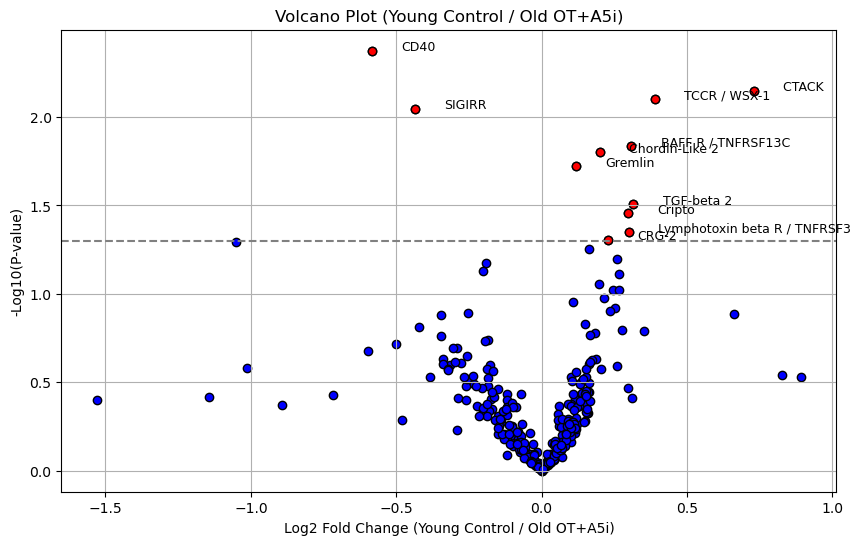

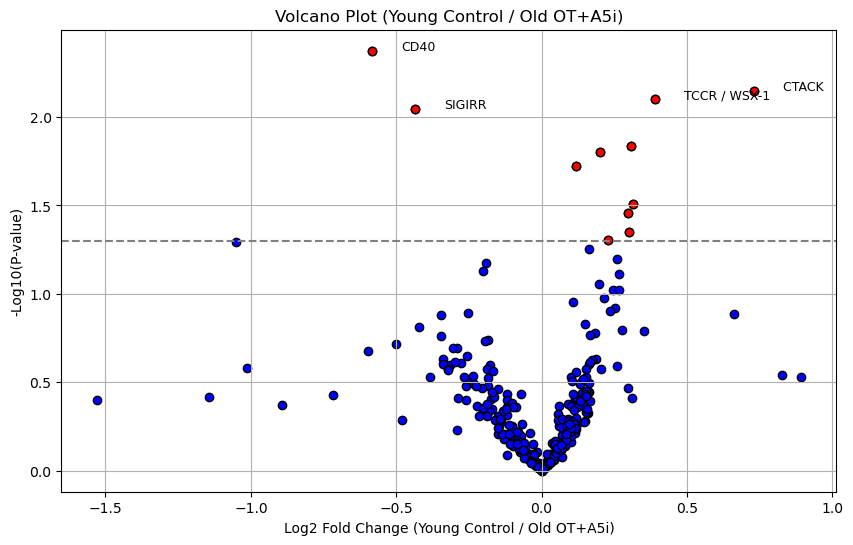

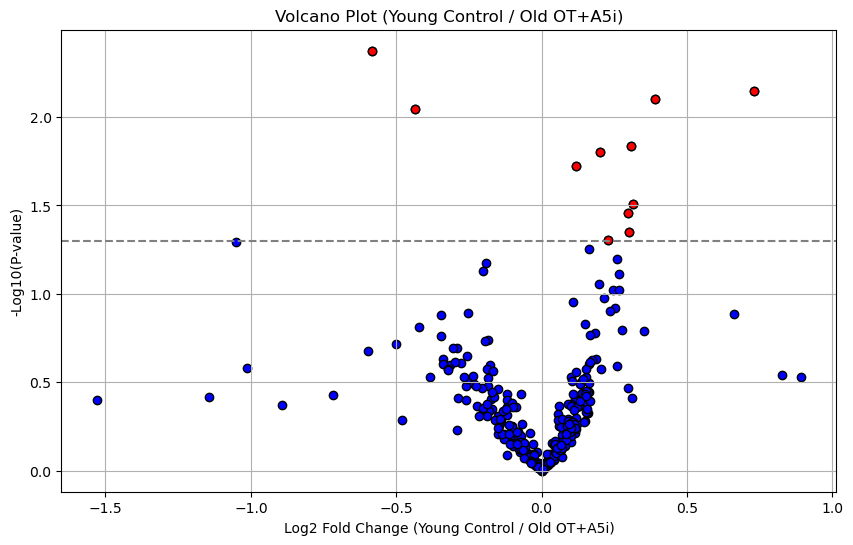

Significant proteins (p-value < 0.05) with Levene's test p-values, standard deviations, and standard deviation ratios:
                 Protein  Std Dev Group1  Std Dev Group2  \
21                   BLC        0.002630        0.000677   
26     CCL4 / MIP-1 beta        0.002159        0.000679   
39                 CD30         0.001730        0.000366   
72                 EGF R        0.002862        0.001311   
81                  FADD        0.002533        0.000865   
122               ICAM-5        0.001392        0.000610   
124  IFN-alpha / beta R1        0.001994        0.000601   
126             IFN-beta        0.002500        0.001052   
138            IL-1 beta        0.002515        0.000659   
139        IL-1 R4 / ST2        0.001667        0.000769   
146                IL-11        0.003396        0.000991   
187         IL-5 R alpha        0.002130        0.000588   
217                  MIG        0.002671        0.001085   
247               RANTES        0.001055 

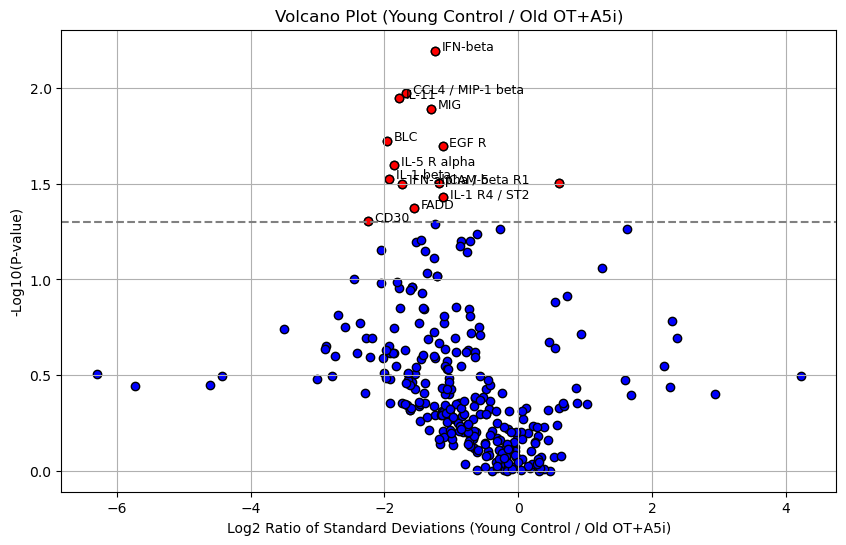

In [4]:
#"Enter 'paired' for paired T-test or 'unpaired' for unpaired T-test: "
#Set eq_var to True for unpaired T-test if there is expected to be equal variance
file_path = '10.25.24_Serum_ANL+AHA_Sep.xlsx'
df = pd.read_excel(file_path, header=None)

comparison_type = 'unpaired'
eq_var = False
fold_change_thresh = 2
benjamini_hochberg = 0
Group1 = 'Old OT+A5i'
Group2 = 'Young Control'
unpaired_g1_treat, unpaired_g1_age, unpaired_g1_sex = 'E', 'O', 'B'
unpaired_g2_treat, unpaired_g2_age, unpaired_g2_sex = 'C', 'Y', 'B'

paired_g1_treat, paired_g1_age, paired_g1_sex = 'E', 'B', 'F' 
paired_g2_treat, paired_g2_age, paired_g2_sex = 'E', 'A', 'F'

# Process the input data
# First row: Sample IDs
sample_ids = df.iloc[0, 1:]

# Second row: Treatment
treatments = df.iloc[1, 1:]

# Third row: Age
ages = df.iloc[2, 1:]

# Fourth row: Sex
sexes = df.iloc[3, 1:]

# Protein names (1st column)
proteins = df.iloc[4:, 0]

# Protein expression data (everything from row 5 onward, excluding the first column)
expression_data = df.iloc[4:, 1:].T
expression_data.columns = proteins  # Set protein names as column headers

# Function to perform paired T-test (e.g., Age "B" & Treatment "E" vs Age "A" & Treatment "E")
def paired_t_test():
    # Filter for Group 1: Age = "B", Treatment = "E", and Sex = "M"
    group1_mask = (treatments == paired_g1_treat) & (ages == paired_g1_age) & (sexes == paired_g1_sex)
    group1_data = expression_data[group1_mask]

    # Filter for Group 2: Age = "A", Treatment = "E", and Sex = "M"
    group2_mask = (treatments == paired_g2_treat) & (ages == paired_g2_age) & (sexes == paired_g2_sex)
    group2_data = expression_data[group2_mask]

    # Ensure both groups have the same samples (IDs)
    group1_sample_ids = sample_ids[group1_mask]
    group2_sample_ids = sample_ids[group2_mask]

    # Match samples based on their IDs
    paired_samples = group1_sample_ids[group1_sample_ids.isin(group2_sample_ids)]

    # Extract data for the matched samples
    group1_matched = group1_data.loc[group1_sample_ids.isin(paired_samples)]
    group2_matched = group2_data.loc[group2_sample_ids.isin(paired_samples)]

    # Perform paired T-test on each protein
    p_values = []
    for protein in proteins:
        t_stat, p_val = ttest_rel(group1_matched[protein], group2_matched[protein])
        p_values.append((protein, p_val))

    # Convert the results into a DataFrame and filter for significant differences
    pval_df = pd.DataFrame(p_values, columns=['Protein', 'P-value'])
    if benjamini_hochberg ==1:
        # Perform Benjamini-Hochberg correction
        pvals = pval_df['P-value']
        _, bh_corrected_pvals, _, _ = multipletests(pvals, method='fdr_bh')
        
        # Add the corrected p-values to the DataFrame
        pval_df['P-value'] = bh_corrected_pvals   
    significant_proteins = pval_df[pval_df['P-value'] < 0.05]

    # Print the proteins with significant differences and their p-values
    print("Paired T-test: Proteins with significant differences (P < 0.05):")
    print(significant_proteins)
    print(list(significant_proteins['Protein']))
    return pval_df

# Function to perform unpaired T-test (e.g., Age "A" & Treatment "E" vs Age "A" & Treatment "C")
def unpaired_t_test():
    # Filter for Group 1: Age = "A", Treatment = "E", and Sex = "F"
    group1_mask = (treatments == unpaired_g1_treat) & (ages == unpaired_g1_age) & (sexes == unpaired_g1_sex)
    group1_data = expression_data[group1_mask]

    # Filter for Group 2: Age = "A", Treatment = "C", and Sex = "F"
    group2_mask = (treatments == unpaired_g2_treat) & (ages == unpaired_g2_age) & (sexes == unpaired_g2_sex)
    group2_data = expression_data[group2_mask]

    # Perform unpaired T-test on each protein
    p_values = []
    for protein in proteins:
        t_stat, p_val = ttest_ind(list(group1_data[protein]), list(group2_data[protein]), equal_var=eq_var)
        p_values.append((protein, p_val))

    # Convert the results into a DataFrame and filter for significant differences
    pval_df = pd.DataFrame(p_values, columns=['Protein', 'P-value'])
    if benjamini_hochberg ==1:
        # Perform Benjamini-Hochberg correction
        pvals = pval_df['P-value']
        _, bh_corrected_pvals, _, _ = multipletests(pvals, method='fdr_bh')
        
        # Add the corrected p-values to the DataFrame
        pval_df['P-value'] = bh_corrected_pvals    

    significant_proteins = pval_df[pval_df['P-value'] < 0.05]

    # Print the proteins with significant differences and their p-values
    print("Unpaired T-test: Proteins with significant differences (P < 0.05):")
    print(significant_proteins)
    print(list(significant_proteins['Protein']))
    return pval_df

if comparison_type == 'paired':
    pval_df = paired_t_test()
elif comparison_type == 'unpaired':
    pval_df = unpaired_t_test()
else:
    print("Invalid input. Please enter either 'paired' or 'unpaired'.")

# Volcano Plot Below
if comparison_type == 'unpaired':
    group1_mask = (treatments == unpaired_g1_treat) & (ages == unpaired_g1_age) & (sexes == unpaired_g1_sex)
    group2_mask = (treatments == unpaired_g2_treat) & (ages == unpaired_g2_age) & (sexes == unpaired_g2_sex)

elif comparison_type == 'paired':
    group1_mask = (treatments == paired_g1_treat) & (ages == paired_g1_age) & (sexes == paired_g1_sex)
    group2_mask = (treatments == paired_g2_treat) & (ages == paired_g2_age) & (sexes == paired_g2_sex)

# Filter the expression data for each group
group1_data = expression_data[group1_mask]
group2_data = expression_data[group2_mask]

# Calculate the average fold change for each protein as the log2(Group 2 mean / Group 1 mean)
fold_changes = np.log2(group2_data.mean() / group1_data.mean())

# Prepare the volcano plot
pval_df['Log2 Fold Change'] = fold_changes.values
pval_df['-log10(P-value)'] = -np.log10(pval_df['P-value'])

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(pval_df['Log2 Fold Change'], pval_df['-log10(P-value)'], color='blue', edgecolor='black')

# Highlight significant proteins (p-value < 0.05)
significant_proteins = pval_df[pval_df['P-value'] < 0.05]
print(significant_proteins)
plt.scatter(significant_proteins['Log2 Fold Change'], significant_proteins['-log10(P-value)'], color='red', edgecolor='black')

# Add labels for significant proteins
for i, row in significant_proteins.iterrows():
    plt.text(row['Log2 Fold Change'] + 0.1, row['-log10(P-value)'], row['Protein'], fontsize=9, color='black')

# Label plot
plt.title('Volcano Plot ('+Group2+' / '+Group1+')')
plt.xlabel('Log2 Fold Change ('+Group2+' / '+Group1+')')
plt.ylabel('-Log10(P-value)')
plt.axhline(y=-np.log10(0.05), color='grey', linestyle='--')
plt.grid(True)

# Show plot
plt.show()

#UPDATED PLOT
# Prepare the volcano plot
pval_df['Log2 Fold Change'] = fold_changes.values
pval_df['-log10(P-value)'] = -np.log10(pval_df['P-value'])

# Filter significant proteins (p-value < 0.05)
significant_proteins = pval_df[pval_df['P-value'] < 0.05]

# Get the top 4 proteins with the highest values on the y-axis (-log10(P-value))
top_y_proteins = significant_proteins.nlargest(4, '-log10(P-value)')

# Get the top 4 proteins with the largest absolute values on the x-axis (log2 fold change)
top_x_proteins = significant_proteins.loc[significant_proteins['Log2 Fold Change'].abs().nlargest(4).index]

# Combine these proteins (avoiding duplicates by using pd.concat and dropping duplicates)
proteins_to_label = pd.concat([top_y_proteins, top_x_proteins]).drop_duplicates()

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(pval_df['Log2 Fold Change'], pval_df['-log10(P-value)'], color='blue', edgecolor='black')

# Highlight significant proteins (p-value < 0.05)
plt.scatter(significant_proteins['Log2 Fold Change'], significant_proteins['-log10(P-value)'], color='red', edgecolor='black')

# Add labels for the selected proteins
for i, row in proteins_to_label.iterrows():
    plt.text(row['Log2 Fold Change'] + 0.1, row['-log10(P-value)'], row['Protein'], fontsize=9, color='black')

# Label plot
plt.title('Volcano Plot (' + Group2 + ' / ' + Group1 + ')')
plt.xlabel('Log2 Fold Change (' + Group2 + ' / ' + Group1 + ')')
plt.ylabel('-Log10(P-value)')
plt.axhline(y=-np.log10(0.05), color='grey', linestyle='--')
plt.grid(True)

# Show plot
plt.show()

# Threshold for Log2 Fold Change
fc_threshold = np.log2(fold_change_thresh)  # Approximately 0.585

# Calculate the average fold change for each protein as the log2(Group 2 mean / Group 1 mean)
fold_changes = np.log2(group2_data.mean() / group1_data.mean())

# Prepare the volcano plot data
pval_df['Log2 Fold Change'] = fold_changes.values
pval_df['-log10(P-value)'] = -np.log10(pval_df['P-value'])

# Plot the volcano plot
plt.figure(figsize=(10, 6))
plt.scatter(pval_df['Log2 Fold Change'], pval_df['-log10(P-value)'], color='blue', edgecolor='black')

# Highlight significant proteins (p-value < 0.05)
significant_proteins = pval_df[pval_df['P-value'] < 0.05]
plt.scatter(significant_proteins['Log2 Fold Change'], significant_proteins['-log10(P-value)'], color='red', edgecolor='black')

# Add labels only for significant proteins with Log2 Fold Change > log2(1.5) or < -log2(1.5)
for i, row in significant_proteins.iterrows():
    if abs(row['Log2 Fold Change']) > fc_threshold:  # Check if it meets the fold change threshold
        plt.text(row['Log2 Fold Change'] + 0.1, row['-log10(P-value)'], row['Protein'], fontsize=9, color='black')

# Label plot
plt.title('Volcano Plot ('+Group2+' / '+Group1+')')
plt.xlabel('Log2 Fold Change ('+Group2+' / '+Group1+')')
plt.ylabel('-Log10(P-value)')
plt.axhline(y=-np.log10(0.05), color='grey', linestyle='--')
plt.grid(True)

# Show plot
plt.show()

# Calculate the standard deviations and the log2 ratio of standard deviations for each protein
std_group1 = group1_data.std(ddof=1)
std_group2 = group2_data.std(ddof=1)
log2_std_ratio = np.log2(std_group2 / std_group1)

# Perform Levene's test for each protein to calculate p-values for variance differences
p_values = [levene(group1_data[protein], group2_data[protein])[1] for protein in proteins]
if benjamini_hochberg ==1:
    _, bh_corrected_pvals, _, _ = multipletests(p_values, method='fdr_bh')
    p_values = bh_corrected_pvals

# Create DataFrame for output and plotting
pval_df = pd.DataFrame({
    'Protein': proteins,
    'Std Dev Group1': std_group1.values,
    'Std Dev Group2': std_group2.values,
    'Std Ratio (Group2/Group1)': std_group2.values / std_group1.values,
    'Log2 Std Ratio': log2_std_ratio.values,
    'P-value (Levene)': p_values,
    '-log10(P-value)': -np.log10(p_values)
})

# Filter to only include proteins with p-value < 0.05
significant_proteins_df = pval_df[pval_df['P-value (Levene)'] < 0.05]

# Print significant proteins with their statistics
print("Significant proteins (p-value < 0.05) with Levene's test p-values, standard deviations, and standard deviation ratios:")
print(significant_proteins_df)
print(list(significant_proteins_df['Protein']))
# Further split the significant proteins based on Log2 Std Ratio
significant_positive_log2 = significant_proteins_df[significant_proteins_df['Log2 Std Ratio'] > 0]
significant_negative_log2 = significant_proteins_df[significant_proteins_df['Log2 Std Ratio'] < 0]
# Print lists of proteins based on Log2 Std Ratio
print("Significant proteins with Log2 Std Ratio > 0:")
print(list(significant_positive_log2['Protein']))

print("Significant proteins with Log2 Std Ratio < 0:")
print(list(significant_negative_log2['Protein']))


# Plot the volcano plot
plt.figure(figsize=(10, 6))
plt.scatter(pval_df['Log2 Std Ratio'], pval_df['-log10(P-value)'], color='blue', edgecolor='black')

# Highlight significant proteins (p-value < 0.05)
plt.scatter(significant_proteins_df['Log2 Std Ratio'], significant_proteins_df['-log10(P-value)'], color='red', edgecolor='black')

# Add labels only for significant proteins with Log2 Std Ratio > log2(fold_change_thresh) or < -log2(fold_change_thresh)
fc_threshold_log2 = np.log2(fold_change_thresh)
for i, row in significant_proteins_df.iterrows():
    if abs(row['Log2 Std Ratio']) > fc_threshold_log2:
        plt.text(row['Log2 Std Ratio'] + 0.1, row['-log10(P-value)'], row['Protein'], fontsize=9, color='black')

# Label plot
plt.title('Volcano Plot (' + Group2 + ' / ' + Group1 + ')')
plt.xlabel('Log2 Ratio of Standard Deviations (' + Group2 + ' / ' + Group1 + ')')
plt.ylabel('-Log10(P-value)')
plt.axhline(y=-np.log10(0.05), color='grey', linestyle='--')
plt.grid(True)

# Show plot
plt.show()

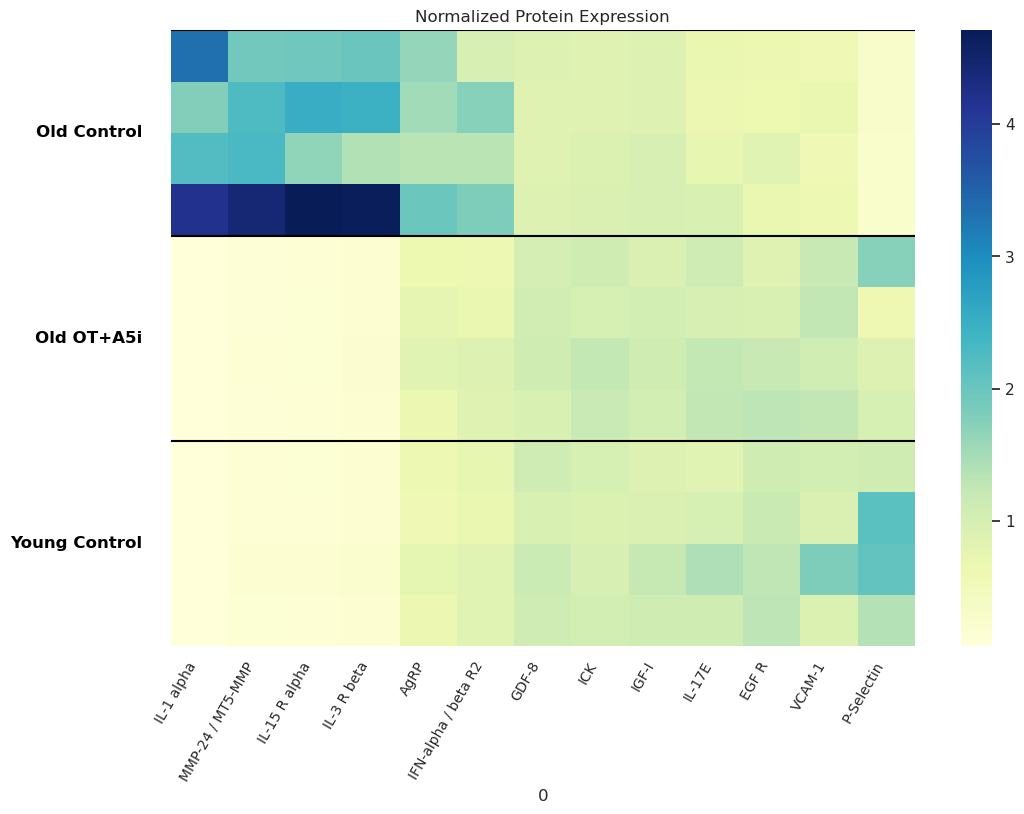

print to copy


In [4]:
file_path = '10.25.24_Serum_ANL+AHA_Sep.xlsx'
df = pd.read_excel(file_path, header=None)

# Filter data for specific proteins
plot_proteins = ['IL-1 alpha', 'MMP-24 / MT5-MMP', 'IL-15 R alpha', 'IL-3 R beta', 'AgRP', 'IFN-alpha / beta R2', 'GDF-8', 'ICK', 'IGF-I', 'IL-17E', 'EGF R', 'VCAM-1','P-Selectin']

# Define group dictionary based on treatments, ages, and sexes
Group_dic = {
    'Old Control': ['C', 'O', 'B'],
    'Old OT+A5i': ['E', 'O', 'B'],
    'Young Control': ['C', 'Y', 'B'],
}

# Process input data
sample_ids = df.iloc[0, 1:]
treatments = df.iloc[1, 1:]
ages = df.iloc[2, 1:]
sexes = df.iloc[3, 1:]
proteins = df.iloc[4:, 0]
expression_data = df.iloc[4:, 1:].T
expression_data.columns = proteins

# Select only specified proteins
expression_data = expression_data[plot_proteins]

# Convert data to numeric, setting non-numeric values to NaN (or fillna(0) if needed)
expression_data = expression_data.apply(pd.to_numeric, errors='coerce').fillna(0)

# Function to assign group labels based on treatments, ages, and sexes
def assign_group(treatment, age, sex):
    for group, criteria in Group_dic.items():
        if [treatment, age, sex] == criteria:
            return group
    return 'Other'

# Apply the function to create group labels for each sample
group_labels = [assign_group(t, a, s) for t, a, s in zip(treatments, ages, sexes)]
expression_data['Group'] = group_labels  # Add group labels as a column

# Filter to include only the specified groups in Group_dic and sort by group
expression_data_filtered = expression_data[expression_data['Group'].isin(Group_dic.keys())]
expression_data_filtered = expression_data_filtered.sort_values('Group')

# Remove the 'Group' column after sorting and set the index to group labels for plotting
group_labels_sorted = expression_data_filtered.pop('Group')
expression_data_normalized = expression_data_filtered / expression_data_filtered.mean()

# Plot heatmap with a single label for each group
sns.set(style="white")
plt.figure(figsize=(12, 8))  # Increase figure width for better spacing of x-ticks
g = sns.heatmap(expression_data_normalized, cmap="YlGnBu", cbar=True, yticklabels=False, xticklabels=plot_proteins)

# Rotate x-tick labels, adjust font size, and set alignment
plt.xticks(rotation=60, ha='right', fontsize=10)  # Adjust rotation and font size for readability

# Add group name and bar separator for each group in black
current_y = 0
for group in Group_dic.keys():
    count = (group_labels_sorted == group).sum()
    plt.text(-0.5, current_y + count / 2, group, ha='right', va='center', fontweight='bold', color='black')
    g.axhline(current_y, color="black", linewidth=1.5)
    current_y += count

# Set labels and title
plt.title("Normalized Protein Expression")
plt.show()
print('print to copy')

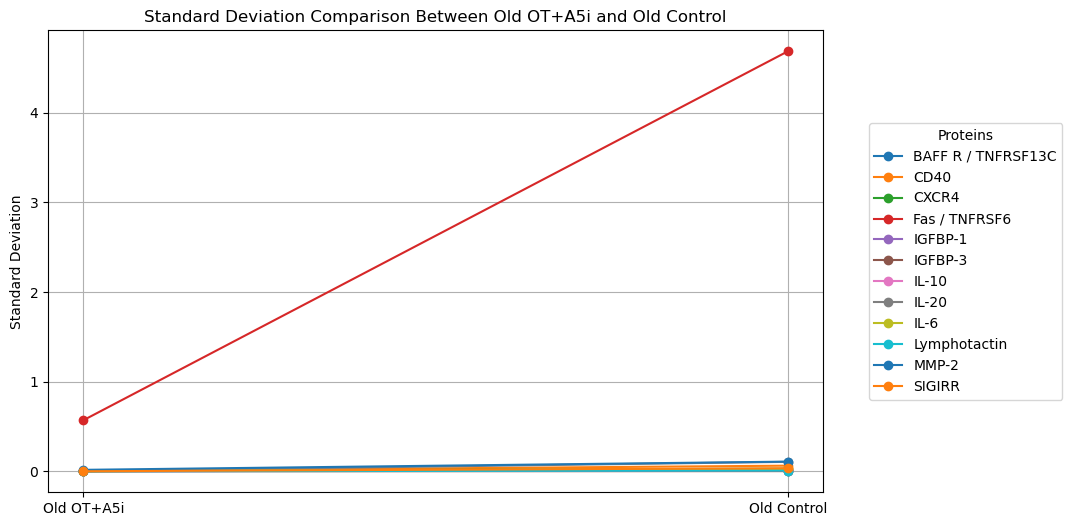

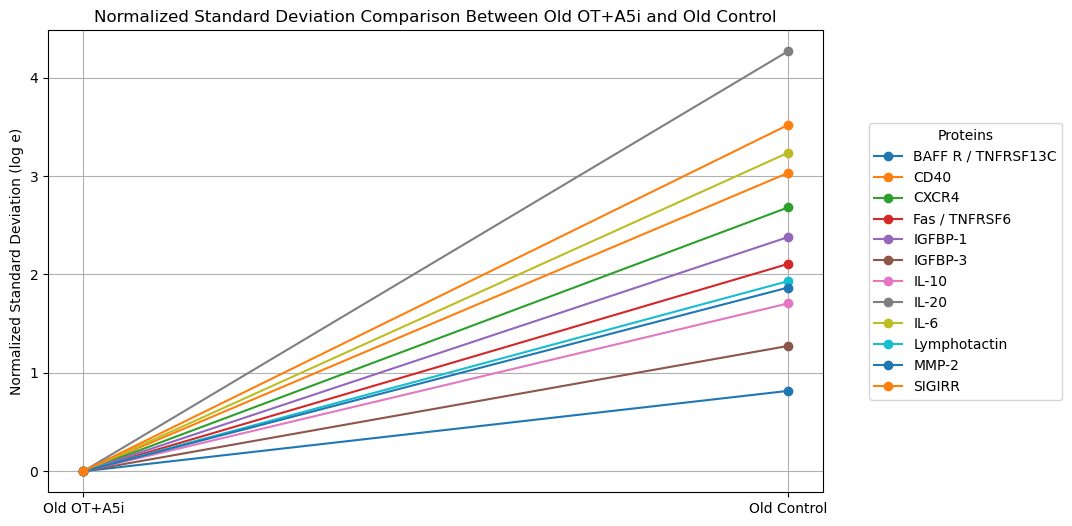

Average SD fold change: e^2.400315152122847
Standard deviation comparison plots generated.


In [5]:
# Load the Excel sheet (replace 'your_file.xlsx' with your actual file name)
file_path = '10.25.24_Serum_ANL+AHA_Sep.xlsx'
df = pd.read_excel(file_path, header=None)
manual_prot = ['BAFF R / TNFRSF13C', 'CD40', 'CXCR4', 'Fas / TNFRSF6', 'IGFBP-1', 'IGFBP-3', 'IL-10', 'IL-20', 'IL-6', 'Lymphotactin', 'MMP-2', 'SIGIRR']

# Define the group dictionary with three criteria
Group_dic = {
    'Old OT+A5i': ['E', 'O', 'B'],
    'Old Control': ['C', 'O', 'B'],
}

# Process the input data
sample_ids = df.iloc[0, 1:]
treatments = df.iloc[1, 1:]
ages = df.iloc[2, 1:]
sexes = df.iloc[3, 1:]
proteins = df.iloc[4:, 0]
expression_data = df.iloc[4:, 1:].T
expression_data.columns = proteins

# Extract groups based on Group_dic criteria
groups_data = {}
for group_name, (treatment, age, sex) in Group_dic.items():
    groups_data[group_name] = expression_data[
        (treatments == treatment) & 
        (ages == age) & 
        (sexes == sex)
    ]

# Select proteins if manual_prot is provided
if manual_prot:
    proteins_to_plot = manual_prot
    for group_name in groups_data:
        groups_data[group_name] = groups_data[group_name][proteins_to_plot]
else:
    proteins_to_plot = list(proteins)

# Calculate standard deviations for each protein in each group
std_devs = {group_name: group_data.std(axis=0) for group_name, group_data in groups_data.items()}

# Create a DataFrame with standard deviations for both groups
group_keys = list(Group_dic.keys())
std_df = pd.DataFrame({
    'Protein': proteins_to_plot,
    f'STD_{group_keys[0]}': std_devs[group_keys[0]],
    f'STD_{group_keys[1]}': std_devs[group_keys[1]]
})

# Plot raw standard deviations for both groups with lines connecting them
plt.figure(figsize=(10, 6))
for i, protein in enumerate(std_df['Protein']):
    plt.plot([1, 2], [std_df[f'STD_{group_keys[0]}'][i], std_df[f'STD_{group_keys[1]}'][i]], marker='o', label=protein if manual_prot else "")
plt.xticks([1, 2], [group_keys[0], group_keys[1]])  # Use dictionary keys for x-tick labels
plt.ylabel('Standard Deviation')
plt.title(f'Standard Deviation Comparison Between {group_keys[0]} and {group_keys[1]}')
if manual_prot:
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title='Proteins')
plt.grid(True)
plt.show()

# Normalize the standard deviations by dividing by the first group's values
std_df['Normalized_STD'] = std_df[f'STD_{group_keys[1]}'] / std_df[f'STD_{group_keys[0]}']
# Take the natural logarithm of the normalized values
std_df['Log_Normalized_STD'] = np.log(std_df['Normalized_STD'])

# Plot normalized standard deviations
plt.figure(figsize=(10, 6))
for i, protein in enumerate(std_df['Protein']):
    plt.plot([1, 2], [0, std_df['Log_Normalized_STD'][i]], marker='o', label=protein if manual_prot else "")
plt.xticks([1, 2], [group_keys[0], group_keys[1]])  # Use dictionary keys for x-tick labels
plt.ylabel('Normalized Standard Deviation (log e)')
plt.title(f'Normalized Standard Deviation Comparison Between {group_keys[0]} and {group_keys[1]}')
if manual_prot:
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title='Proteins')
plt.grid(True)
plt.show()

print(f'Average SD fold change: e^{statistics.mean(std_df["Log_Normalized_STD"])}')
print("Standard deviation comparison plots generated.")

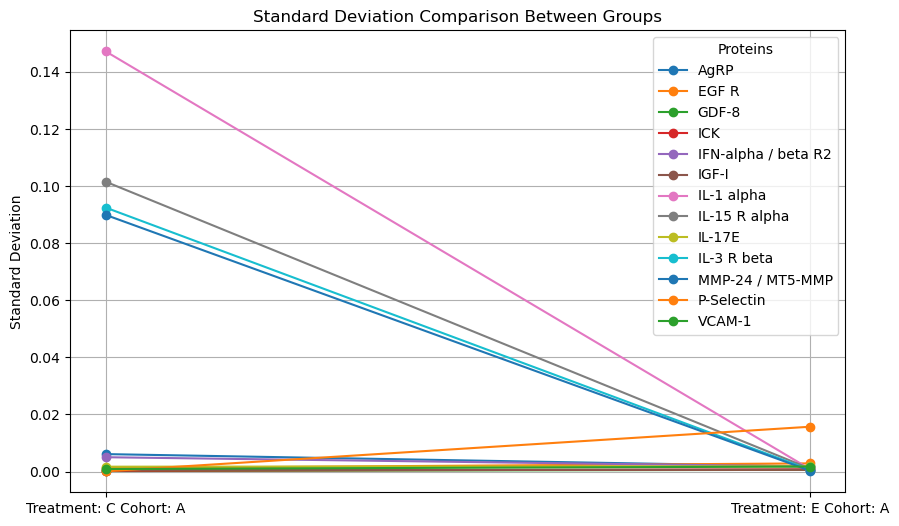

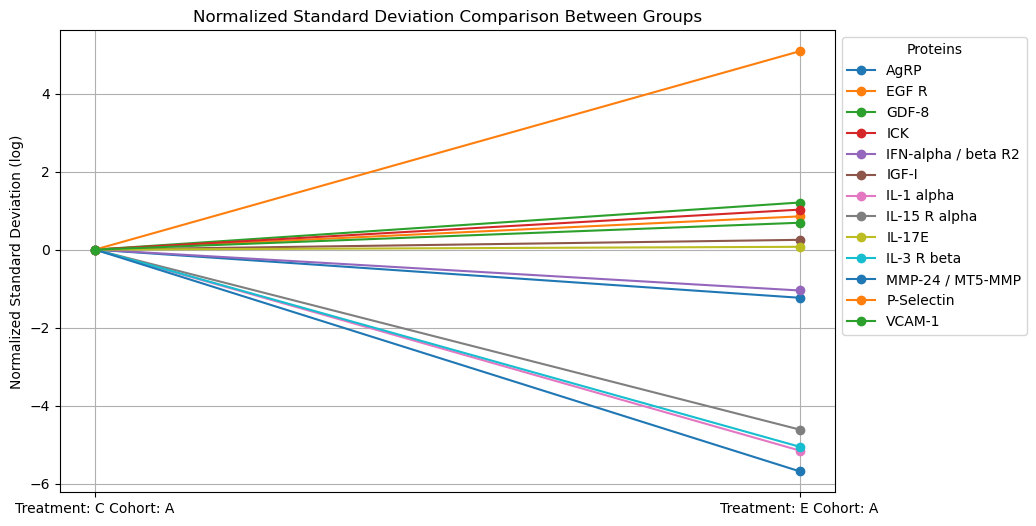

Average SD fold change: e^ -1.0463621482705139
Standard deviation comparison plots generated.


In [2]:
# Load the Excel sheet (replace 'your_file.xlsx' with your actual file name)
# Input for manual proteins or False to use all

file_path = 'A5iOT_Serum BONCAT.xlsx'
df = pd.read_excel(file_path, header=None)
manual_prot = ['AgRP', 'EGF R', 'GDF-8', 'ICK', 'IFN-alpha / beta R2', 'IGF-I', 'IL-1 alpha', 'IL-15 R alpha', 'IL-17E', 'IL-3 R beta', 'MMP-24 / MT5-MMP', 'P-Selectin', 'VCAM-1']
G1_treat,G1_age = 'C','A'
G2_treat, G2_age = 'E','A'

# Process the input data
# First row: Sample IDs
sample_ids = df.iloc[0, 1:]

# Second row: Treatment
treatments = df.iloc[1, 1:]

# Third row: Age
ages = df.iloc[2, 1:]

# Protein names (1st column)
proteins = df.iloc[3:, 0]

# Protein expression data (everything from row 4 onward, excluding the first column)
expression_data = df.iloc[3:, 1:].T
expression_data.columns = proteins  # Set protein names as column headers

# Filter the data for the two groups: treatment 'E', age 'B' and 'A'
group1 = expression_data[(treatments == G1_treat) & (ages == G1_age)]  # Pre-treatment group
group2 = expression_data[(treatments == G2_treat) & (ages == G2_age)]  # Post-treatment group

# Select proteins if manual_prot is provided
if manual_prot:
    proteins_to_plot = manual_prot
    group1 = group1[proteins_to_plot]
    group2 = group2[proteins_to_plot]
else:
    proteins_to_plot = list(proteins)  # Use all proteins

# Calculate standard deviations for each protein in both groups
std_group1 = group1.std(axis=0)
std_group2 = group2.std(axis=0)

# Create a DataFrame with standard deviations for both groups
std_df = pd.DataFrame({
    'Protein': proteins_to_plot,
    'STD_Group1': std_group1,
    'STD_Group2': std_group2
})

# Plot raw standard deviations for both groups with lines connecting them
plt.figure(figsize=(10, 6))
for i, protein in enumerate(std_df['Protein']):
    plt.plot([1, 2], [std_df['STD_Group1'][i], std_df['STD_Group2'][i]], marker='o', label=protein if manual_prot else "")
plt.xticks([1, 2], ['Treatment: '+str(G1_treat)+' Cohort: '+str(G1_age), 'Treatment: '+str(G2_treat)+' Cohort: '+str(G2_age)])
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation Comparison Between Groups')
if manual_prot:
    plt.legend(loc='best', bbox_to_anchor=(1, 1), title='Proteins')
plt.grid(True)
plt.show()

# Normalize the standard deviations by dividing by Group 1 values
std_df['Normalized_STD'] = std_df['STD_Group2'] / std_df['STD_Group1']
# Take the natural logarithm of the normalized values
std_df['Log_Normalized_STD'] = np.log(std_df['Normalized_STD'])

# Plot normalized standard deviations
plt.figure(figsize=(10, 6))
for i, protein in enumerate(std_df['Protein']):
    plt.plot([1, 2], [0, std_df['Log_Normalized_STD'][i]], marker='o', label=protein if manual_prot else "")
plt.xticks([1, 2], ['Treatment: '+str(G1_treat)+' Cohort: '+str(G1_age), 'Treatment: '+str(G2_treat)+' Cohort: '+str(G2_age)])
plt.ylabel('Normalized Standard Deviation (log)')
plt.title('Normalized Standard Deviation Comparison Between Groups')
if manual_prot:
    plt.legend(loc='best', bbox_to_anchor=(1, 1), title='Proteins')
plt.grid(True)
plt.show()
print('Average SD fold change: e^', statistics.mean(std_df['Log_Normalized_STD']))
print("Standard deviation comparison plots generated.")


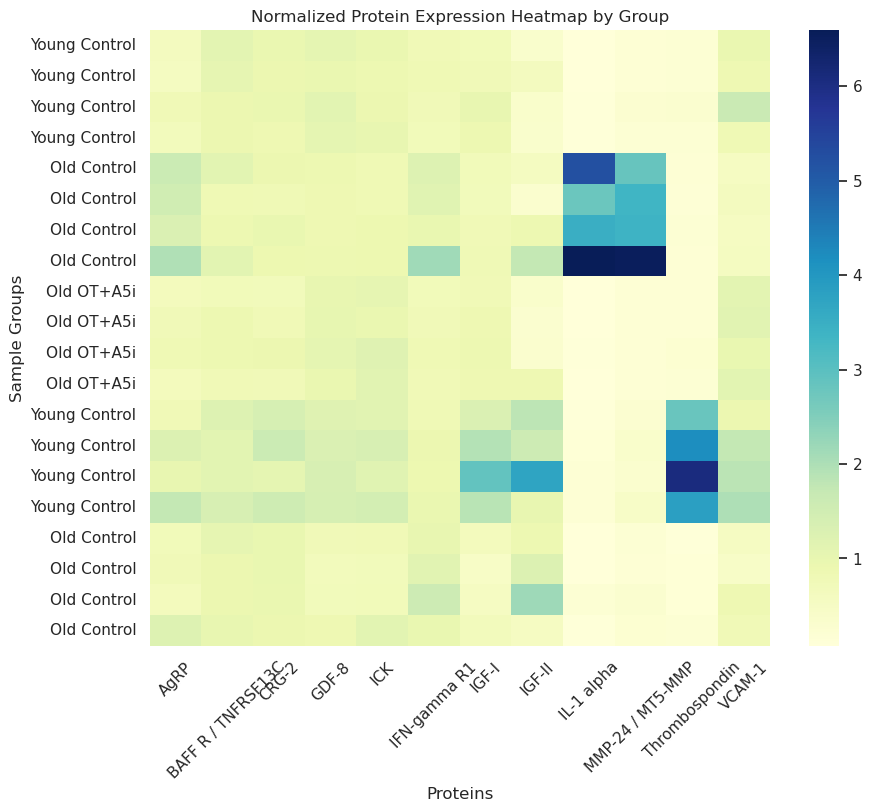

In [76]:
# Load data
file_path = '10.25.24_Serum_ANL+AHA_Comb.xlsx'
df = pd.read_excel(file_path, header=None)

# Process input data
sample_ids = df.iloc[0, 1:]
treatments = df.iloc[1, 1:]
ages = df.iloc[2, 1:]
sexes = df.iloc[3, 1:]
proteins = df.iloc[4:, 0]
expression_data = df.iloc[4:, 1:].T
expression_data.columns = proteins

# Filter data for specific proteins
plot_proteins = ['AgRP', 'BAFF R / TNFRSF13C', 'CRG-2', 'GDF-8', 'ICK', 'IFN-gamma R1', 'IGF-I', 'IGF-II', 'IL-1 alpha', 'MMP-24 / MT5-MMP', 'Thrombospondin', 'VCAM-1']
expression_data = expression_data[plot_proteins]

# Convert data to numeric, setting non-numeric values to NaN (or fillna(0) if needed)
expression_data = expression_data.apply(pd.to_numeric, errors='coerce').fillna(0)

# Define group dictionary based on treatments, ages, and sexes
Group_dic = {
    'Old Control': ['C', 'O', 'B'],
    'Old OT+A5i': ['E', 'O', 'B'],
    'Young Control': ['C', 'Y', 'B'],
}

# Function to assign group labels based on treatments, ages, and sexes
def assign_group(treatment, age, sex):
    for group, criteria in Group_dic.items():
        if [treatment, age, sex] == criteria:
            return group
    return 'Other'

# Apply the function to create group labels for each sample
group_labels = [assign_group(t, a, s) for t, a, s in zip(treatments, ages, sexes)]
expression_data.index = group_labels

# Filter to include only the specified groups in Group_dic
expression_data_filtered = expression_data.loc[expression_data.index.isin(Group_dic.keys())]

# Normalize by dividing each column by its mean
expression_data_normalized = expression_data_filtered / expression_data_filtered.mean()

# Plot heatmap with grouped labels only
plt.figure(figsize=(10, 8))
sns.heatmap(expression_data_normalized, cmap="YlGnBu", cbar=True, yticklabels=expression_data_normalized.index, xticklabels=plot_proteins)
plt.xlabel("Proteins")
plt.ylabel("Sample Groups")
plt.title("Normalized Protein Expression Heatmap by Group")
plt.xticks(rotation=45)
plt.show()


Average standard deviation of proteins for Treadmill Old Control: 0.0057
Average standard deviation of proteins for Treadmill Old OT+A5i: 0.0108


/tmp/ipykernel_89/1030362754.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(proteins_to_plot))


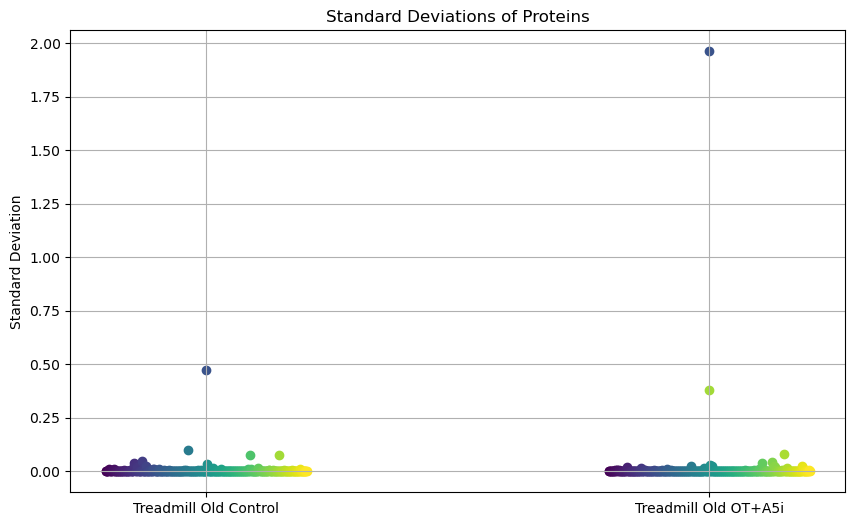

/tmp/ipykernel_89/1030362754.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(proteins_to_plot))


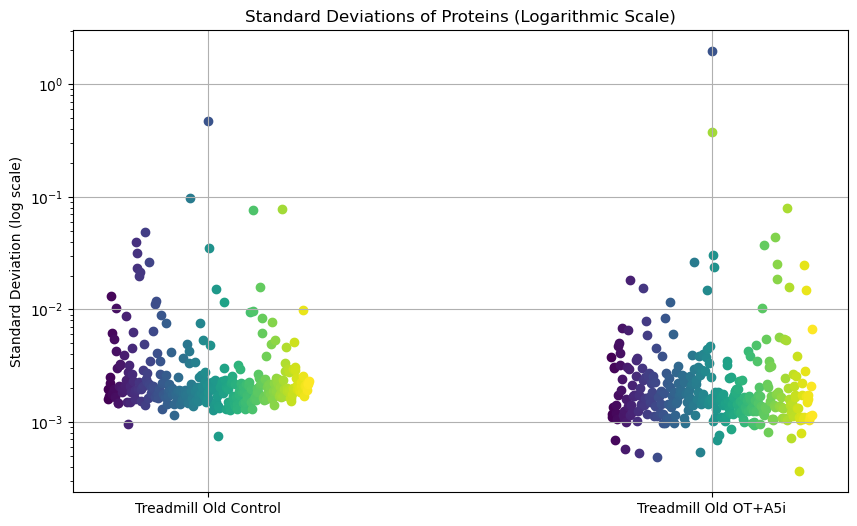

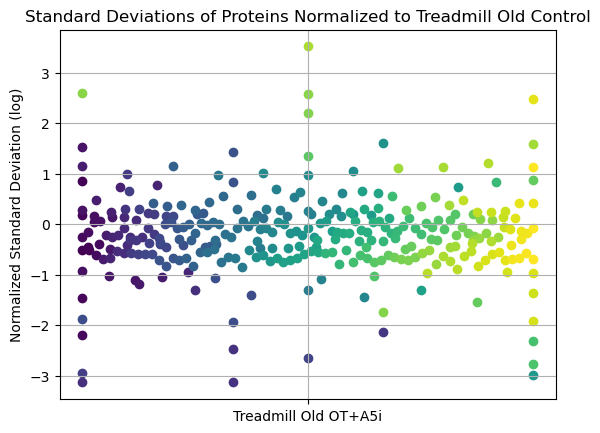

Treadmill Old OT+A5i average SD fold change vs Treadmill Old Control: e^ -0.20742403628276224


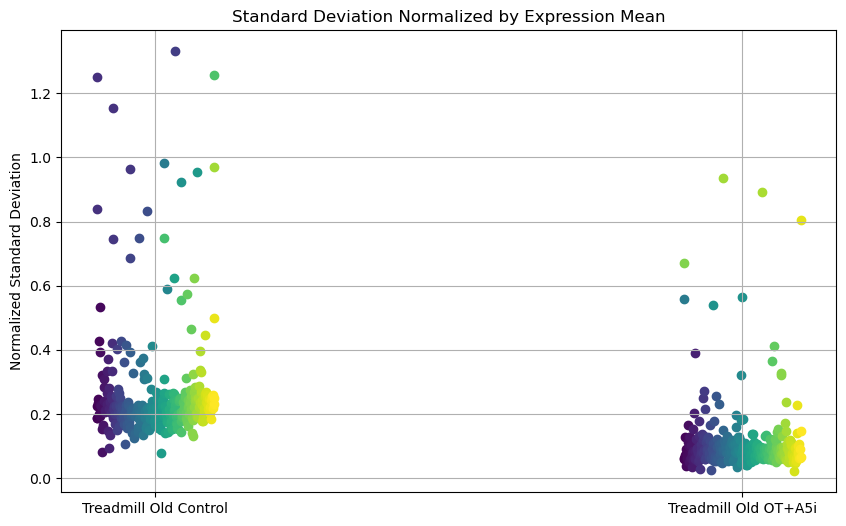

In [4]:
# Levene's test pair settings (set this to the pairs you want)
levene_pairs = [(0, 1), (3, 1), (0, 2),(3,4)]  # e.g., [(0,1), (1,2)] refers to (Group1, Group2)

# Noise Analysis
file_path = '10.25.24_Serum_ANL+AHA_Sep.xlsx'
df = pd.read_excel(file_path, header=None)
manual_prot = False
Group_dic = {'Treadmill Old Control': ['C', 'OE', 'B'], 'Treadmill Old OT+A5i': ['E', 'OE', 'B']}
#{'Old Control AHA': ['C', 'O', 'B'], 'Old OT+A5i AHA': ['E', 'O', 'B'], 'Young Control AHA': ['C', 'Y', 'B'], 'Old Control ANL': ['C', 'O_ANL', 'B'],'Young Control ANL': ['C', 'Y_ANL', 'B']}

# Process the input data
sample_ids = df.iloc[0, 1:]
treatments = df.iloc[1, 1:]
ages = df.iloc[2, 1:]
sexes = df.iloc[3, 1:]
proteins = df.iloc[4:, 0]
expression_data = df.iloc[4:, 1:].T
expression_data.columns = proteins

# Grouping based on conditions
Cohorts = list(Group_dic.values())
Group_data = [expression_data[(treatments == group[0]) & (ages == group[1]) & (sexes == group[2])] for group in Cohorts]

# Select proteins if manual_prot is provided
proteins_to_plot = manual_prot if manual_prot else list(proteins)

# Calculate standard deviations for each protein across all groups
std_group = [group.std(axis=0) for group in Group_data]

# Print average standard deviation for each cohort
for i, cohort in enumerate(Group_dic.keys()):
    avg_std = statistics.mean(std_group[i])
    print(f"Average standard deviation of proteins for {cohort}: {avg_std:.4f}")


# Plot 1: Raw Standard Deviations of Proteins
plt.figure(figsize=(10, 6))
x_values = list(range(len(std_group)))
y_values = [[std_group[group_index][i] for group_index in range(len(std_group))] for i, _ in enumerate(proteins_to_plot)]
x_ext = x_values * len(y_values)
y_comb = [item for sublist in y_values for item in sublist]

# Add jitter to x-values
def jitter_if_close(x_list, y_list, jitter_strength=0.1, y_threshold=0.05):
    jittered_x = list(x_list)
    x_counts = Counter(x_list)
    for i, (x, y) in enumerate(zip(x_list, y_list)):
        count = x_counts[x]
        if count > 1:
            matching_indices = [j for j, x_val in enumerate(x_list) if x_val == x]
            close_y_indices = [j for j in matching_indices if abs(y_list[j] - y) < y_threshold]
            if len(close_y_indices) > 1:
                offsets = np.linspace(-jitter_strength, jitter_strength, len(close_y_indices))
                for offset_index, j in enumerate(close_y_indices):
                    jittered_x[j] = x + offsets[offset_index]
    return jittered_x

# Apply jitter
jittered_x_values = jitter_if_close(x_ext, y_comb, jitter_strength=0.2, y_threshold=0.1)
original_lengths = [len(sublist) for sublist in y_values]
separated_jittered_x = [jittered_x_values[start:start + length] for start, length in zip(np.cumsum([0] + original_lengths[:-1]), original_lengths)]

# Plotting
cmap = cm.get_cmap('viridis', len(proteins_to_plot))
colors = cmap(np.arange(len(proteins_to_plot)))
for i, protein in enumerate(proteins_to_plot):
    plt.scatter(separated_jittered_x[i], y_values[i], marker='o', color=colors[i], label=protein if manual_prot else "")
plt.xticks(list(range(len(Group_dic.keys()))), list(Group_dic.keys()))
plt.ylabel('Standard Deviation')
plt.title('Standard Deviations of Proteins')
if manual_prot:
    plt.legend(loc='best', bbox_to_anchor=(1, 1), title='Proteins')
plt.grid(True)
plt.show()

# Plot 4: Logarithmic Scale of Raw Standard Deviations of Proteins
plt.figure(figsize=(10, 6))
x_values = list(range(len(std_group)))
y_values = [[std_group[group_index][i] for group_index in range(len(std_group))] for i, _ in enumerate(proteins_to_plot)]
x_ext = x_values * len(y_values)
y_comb = [item for sublist in y_values for item in sublist]

# Apply jitter
jittered_x_values = jitter_if_close(x_ext, y_comb, jitter_strength=0.2, y_threshold=0.1)
original_lengths = [len(sublist) for sublist in y_values]
separated_jittered_x = [jittered_x_values[start:start + length] for start, length in zip(np.cumsum([0] + original_lengths[:-1]), original_lengths)]

# Plotting with logarithmic scale
cmap = cm.get_cmap('viridis', len(proteins_to_plot))
colors = cmap(np.arange(len(proteins_to_plot)))
for i, protein in enumerate(proteins_to_plot):
    plt.scatter(separated_jittered_x[i], y_values[i], marker='o', color=colors[i], label=protein if manual_prot else "")
plt.xticks(list(range(len(Group_dic.keys()))), list(Group_dic.keys()))
plt.ylabel('Standard Deviation (log scale)')
plt.title('Standard Deviations of Proteins (Logarithmic Scale)')
plt.yscale('log')  # Set Y-axis to logarithmic scale
if manual_prot:
    plt.legend(loc='best', bbox_to_anchor=(1, 1), title='Proteins')
plt.grid(True)
plt.show()


# Plot 2: Normalized Standard Deviations by Group 1
#Be careful: Ex: Old Control group: Protein A has an SD of 5, Protein B has an SD of 3. Exp: Protein A has an SD of 6, Protein B has an SD of 2. Even though the average SD is the same, normalizing via this method can swing results
normalized_STD = [[std_group[i+1][index] / std_group[0][index] for index, _ in enumerate(proteins_to_plot)] for i in range(len(Cohorts) - 1)]
log_norm_STD = [np.log(STD_list) for STD_list in normalized_STD]
y_comb = [item for sublist in log_norm_STD for item in sublist]
x_ext = [index for index, sublist in enumerate(normalized_STD) for _ in sublist]
jittered_x_values = jitter_if_close(x_ext, y_comb, jitter_strength=0.03, y_threshold=0.2)
separated_jittered_x = [jittered_x_values[start:start + length] for start, length in zip(np.cumsum([0] + [len(sublist) for sublist in normalized_STD][:-1]), [len(sublist) for sublist in normalized_STD])]

# Plotting
for i, protein in enumerate(proteins_to_plot):
    x_to_plot = [separated_jittered_x[group][i] for group in range(len(normalized_STD))]
    y_to_plot = [log_norm_STD[group][i] for group in range(len(normalized_STD))]
    plt.scatter(x_to_plot, y_to_plot, marker='o', color=colors[i], label=protein if manual_prot else "")
plt.ylabel('Normalized Standard Deviation (log)')
plt.title('Standard Deviations of Proteins Normalized to ' + list(Group_dic.keys())[0])
plt.xticks(list(range(len(Group_dic.keys()) - 1)), list(Group_dic.keys())[1:])
if manual_prot:
    plt.legend(loc='best', bbox_to_anchor=(1, 1), title='Proteins')
plt.grid(True)
plt.show()

# Print average SD fold change
for i in range(len(Cohorts) - 1):
    print(f"{list(Group_dic.keys())[i+1]} average SD fold change vs {list(Group_dic.keys())[0]}: e^ {statistics.mean(log_norm_STD[i])}")

# Plot 3: Each SD Normalized by each group's own mean protein expression (without taking the log)
mean_group = [group.mean(axis=0) for group in Group_data]
group_mean_normalized_STD = [[std_group[i][index] / mean_group[i][index] for index, _ in enumerate(proteins_to_plot)] for i in range(len(Cohorts))]
y_comb = [item for sublist in group_mean_normalized_STD for item in sublist]
x_ext = [index for index, sublist in enumerate(group_mean_normalized_STD) for _ in sublist]
jittered_x_values = jitter_if_close(x_ext, y_comb, jitter_strength=0.1, y_threshold=0.2)
separated_jittered_x = [jittered_x_values[start:start + length] for start, length in zip(np.cumsum([0] + [len(sublist) for sublist in group_mean_normalized_STD][:-1]), [len(sublist) for sublist in group_mean_normalized_STD])]

# Plotting (no log for group mean normalized SD)
plt.figure(figsize=(10, 6))
for i, protein in enumerate(proteins_to_plot):
    x_to_plot = [separated_jittered_x[group][i] for group in range(len(group_mean_normalized_STD))]
    y_to_plot = [group_mean_normalized_STD[group][i] for group in range(len(group_mean_normalized_STD))]
    plt.scatter(x_to_plot, y_to_plot, marker='o', color=colors[i], label=protein if manual_prot else "")
plt.ylabel('Normalized Standard Deviation')
plt.title('Standard Deviation Normalized by Expression Mean')
plt.xticks(list(range(len(Group_dic.keys()))), list(Group_dic.keys()))
if manual_prot:
    plt.legend(loc='best', bbox_to_anchor=(1, 1), title='Proteins')
plt.grid(True)
plt.show()

# Levene's test for equal variances between selected groups
#This appears to be innacurate because levene's test compared SD between 2+ groups not grouping entire groups (proteins) for one cohort
#for pair in levene_pairs:
#    stat, p_value = levene(Group_data[pair[0]].std(axis=1), Group_data[pair[1]].std(axis=1))
#    print(f"Levene's test between {list(Group_dic.keys())[pair[0]]} and {list(Group_dic.keys())[pair[1]]}: p-value = {p_value:.4f}")


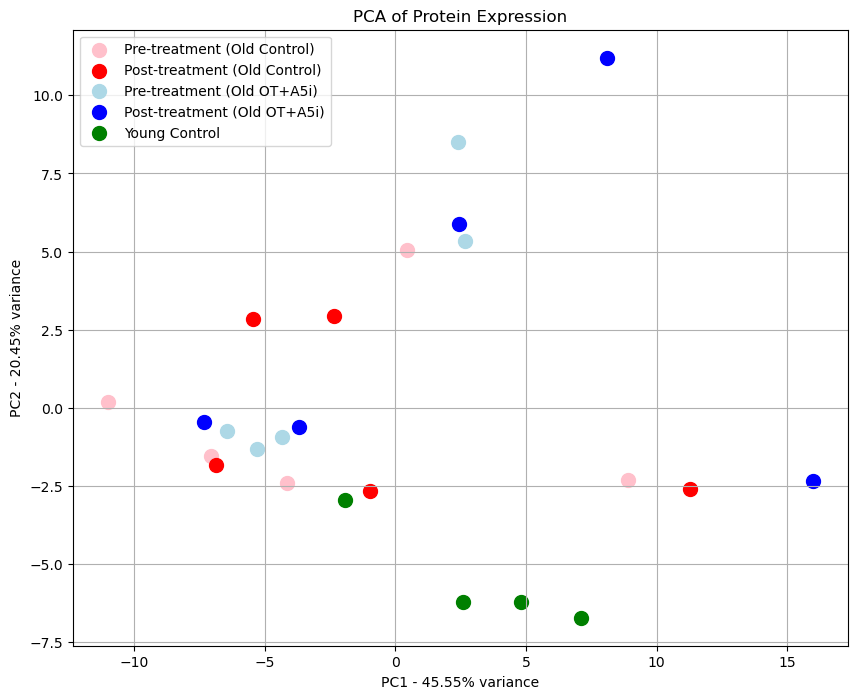

/srv/conda/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


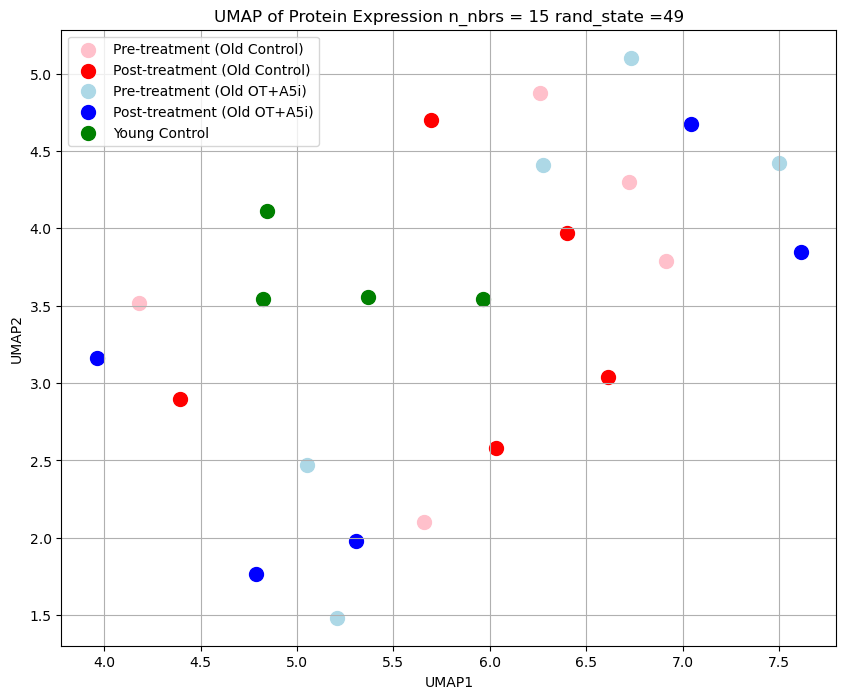

print for copying


In [27]:
# Option to manually enter specific proteins to include in the analysis
#Manual_prot: Enter proteins if desired or False
#neighbors default is 15

file_path = 'Proteomics Mod.xlsx'
df = pd.read_excel(file_path, header=None)
rand_state = 49
n_nbrs = 15
manual_prot = False
#['Granzyme B', 'HVEM / TNFRSF14', 'TCA-3']

# Custom color mapping for each group (modify as needed)
# For example, assign each combination of Treatment and Age a color and label.
group_colors = {
    ('C', 'B'): 'pink',
    ('C', 'A'): 'red',
    ('E', 'B'): '#ADD8E6',
    ('E', 'A'): 'blue',
    ('C', 'Y'): 'green',
}

# Custom legend labels
group_labels = {
    ('C', 'B'): 'Pre-treatment (Old Control)',
    ('C', 'A'): 'Post-treatment (Old Control)',
    ('E', 'B'): 'Pre-treatment (Old OT+A5i)',
    ('E', 'A'): 'Post-treatment (Old OT+A5i)',
    ('C', 'Y'): 'Young Control',
}

# Process the input data
# First row: Sample IDs
sample_ids = df.iloc[0, 1:]

# Second row: Treatment
treatments = df.iloc[1, 1:]

# Third row: Age
ages = df.iloc[2, 1:]

# Protein names (1st column)
proteins = df.iloc[3:, 0]

# Protein expression data (everything from row 4 onward, excluding the first column)
expression_data = df.iloc[3:, 1:].T
expression_data.columns = proteins  # Set protein names as column headers

if manual_prot:
    selected_proteins = manual_prot
    # Filter expression data to only include selected proteins
    expression_data = expression_data[selected_proteins]
else:
    selected_proteins = proteins  # Use all proteins if no specific proteins are provided

# Perform PCA on the expression data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(expression_data)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Treatment'] = treatments.values
pca_df['Age'] = ages.values
pca_df['SampleID'] = sample_ids.values

# Map colors and labels to the DataFrame
pca_df['Group'] = list(zip(pca_df['Treatment'], pca_df['Age']))
pca_df['Color'] = pca_df['Group'].map(group_colors)
pca_df['Label'] = pca_df['Group'].map(group_labels)

# Plot PCA result with custom colors and legend
plt.figure(figsize=(10, 8))

# Create the scatterplot with the custom colors
for group, color in group_colors.items():
    group_data = pca_df[pca_df['Group'] == group]
    plt.scatter(group_data['PC1'], group_data['PC2'], color=color, label=group_labels[group], s=100)

# Customizing the plot
plt.title('PCA of Protein Expression')
plt.xlabel(f'PC1 - {pca.explained_variance_ratio_[0]:.2%} variance')
plt.ylabel(f'PC2 - {pca.explained_variance_ratio_[1]:.2%} variance')
plt.grid(True)

# Add custom legend
plt.legend(loc='best')
plt.show()


# Perform UMAP on the expression data
umap_model = umap.UMAP(n_neighbors=n_nbrs, min_dist=0.1, n_components=2, random_state=rand_state)
umap_result = umap_model.fit_transform(expression_data)

# Create a DataFrame with UMAP results
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'])
umap_df['Treatment'] = treatments.values
umap_df['Age'] = ages.values
umap_df['SampleID'] = sample_ids.values

# Map colors and labels to the DataFrame
umap_df['Group'] = list(zip(umap_df['Treatment'], umap_df['Age']))
umap_df['Color'] = umap_df['Group'].map(group_colors)
umap_df['Label'] = umap_df['Group'].map(group_labels)

# Plot UMAP result with custom colors and legend
plt.figure(figsize=(10, 8))

# Create the scatterplot with the custom colors
for group, color in group_colors.items():
    group_data = umap_df[umap_df['Group'] == group]
    plt.scatter(group_data['UMAP1'], group_data['UMAP2'], color=color, label=group_labels[group], s=100)

# Customizing the plot
plt.title('UMAP of Protein Expression n_nbrs = '+str(n_nbrs)+' rand_state ='+str(rand_state))
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.grid(True)

# Add custom legend
plt.legend(loc='best')
plt.show()
print('print for copying')

/tmp/ipykernel_92/695938920.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(proteins_to_plot))  # 'viridis' is just one example, you can use other colormaps


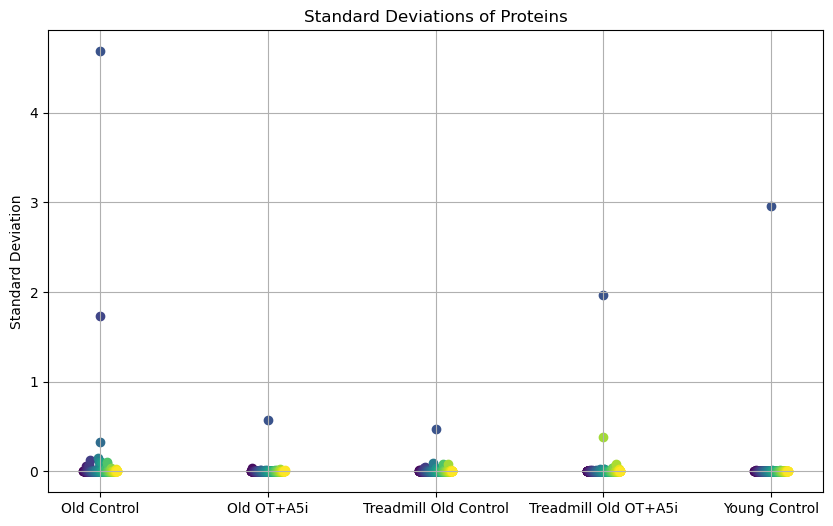

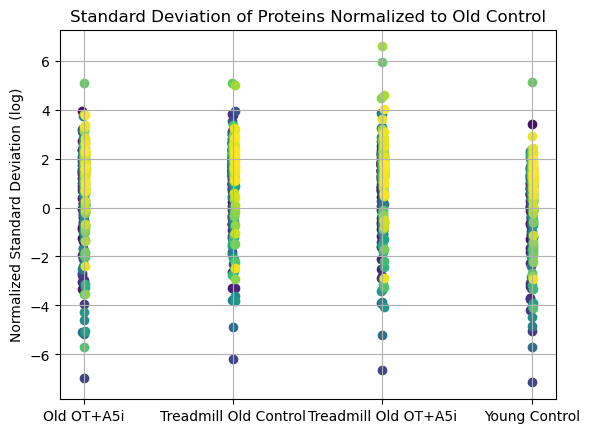

Old OT+A5i  average SD fold change vs Old Control : e^ 0.8384314681130403
Treadmill Old Control  average SD fold change vs Old Control : e^ 1.2411055451854345
Treadmill Old OT+A5i  average SD fold change vs Old Control : e^ 1.0336815089026723
Young Control  average SD fold change vs Old Control : e^ 0.2939405657346723


In [8]:
# Noise Analysis
# Input for manual proteins or False to use all
#For normalization, all groups are normalized by the first group

file_path = '10.22.24_Serum_BONCAT_SexC.xlsx'
df = pd.read_excel(file_path, header=None)
manual_prot = False
Group_dic = {'Old Control': ['C','O','B'], 'Old OT+A5i': ['E','O','B'],'Treadmill Old Control': ['C','OE','B'], 'Treadmill Old OT+A5i': ['E','OE','B'], 'Young Control': ['C','Y','B']}

# Process the input data
# First row: Sample IDs
sample_ids = df.iloc[0, 1:]

# Second row: Treatment
treatments = df.iloc[1, 1:]

# Third row: Age
ages = df.iloc[2, 1:]
sexes = df.iloc[3, 1:]

# Protein names (1st column)
proteins = df.iloc[4:, 0]

# Protein expression data (everything from row 4 onward, excluding the first column)
expression_data = df.iloc[4:, 1:].T
expression_data.columns = proteins  # Set protein names as column headers

# Filter the data for the two groups: treatment 'E', age 'B' and 'A'
Cohorts = list(Group_dic.values())
Group_data = []

for group in Cohorts:
    Group_data.append(expression_data[(treatments == group[0]) & (ages == group[1])& (sexes == group[2])])

# Select proteins if manual_prot is provided
if manual_prot:
    proteins_to_plot = manual_prot
    for index,group in enumerate(Group_data):
        Group_data[index] = Group_data[index][proteins_to_plot]
else:
    proteins_to_plot = list(proteins)  # Use all proteins


# Calculate standard deviations for each protein in both groups
std_group = []
for group in Group_data:
    std_group.append(group.std(axis=0))

def jitter_if_close(x_list, y_list, jitter_strength=0.1, y_threshold=0.05):
    # Initialize the jittered X list with the original X values
    jittered_x = list(x_list)
    
    # Count occurrences of each unique X value
    x_counts = Counter(x_list)
    
    # Apply jitter if needed
    for i, (x, y) in enumerate(zip(x_list, y_list)):
        count = x_counts[x]  # Number of occurrences of this X value
        
        # Check if this X value occurs more than once
        if count > 1:
            # Find all indices where X values match the current X
            matching_indices = [j for j, x_val in enumerate(x_list) if x_val == x]
            
            # Find the indices where Y values are close to the current Y
            close_y_indices = [j for j in matching_indices if abs(y_list[j] - y) < y_threshold]
            
            if len(close_y_indices) > 1:
                # Generate jitter offsets for all close Y values
                offsets = np.linspace(-jitter_strength, jitter_strength, len(close_y_indices))
                
                # Apply jitter to the matching indices
                for offset_index, j in enumerate(close_y_indices):
                    jittered_x[j] = x + offsets[offset_index]
    
    return jittered_x


num_groups = len(std_group)

# Create x-values dynamically based on the number of groups
x_values = list(range(num_groups))
y_values = []
x_counts = Counter(x_values)

# Plotting for each protein across all groups
plt.figure(figsize=(10, 6))

for i, protein in enumerate(proteins_to_plot):
    # Collect the Y values for each protein across all groups
    y_values.append([std_group[group_index][i] for group_index in range(num_groups)])
x_ext = x_values*len(y_values)
y_comb = [item for sublist in y_values for item in sublist]
jittered_x_values = jitter_if_close(x_ext, y_comb, jitter_strength=0.1, y_threshold=0.1)

# Separate the jittered list back into the original lists
# This assumes you know the original lengths of the sublists
original_lengths = [len(sublist) for sublist in y_values]
separated_jittered_x = []
start_index = 0

for length in original_lengths:
    separated_jittered_x.append(jittered_x_values[start_index:start_index + length])
    start_index += length

cmap = cm.get_cmap('viridis', len(proteins_to_plot))  # 'viridis' is just one example, you can use other colormaps
colors = cmap(np.arange(len(proteins_to_plot)))

for i, protein in enumerate(proteins_to_plot):
    plt.scatter(separated_jittered_x[i], y_values[i], marker='o', color=colors[i], label=protein if manual_prot else "")

plt.xticks(list(range(len(Group_dic.keys()))),list(Group_dic.keys()))
plt.ylabel('Standard Deviation')
plt.title('Standard Deviations of Proteins')
if manual_prot:
    plt.legend(loc='best', bbox_to_anchor=(1, 1), title='Proteins')
plt.grid(True)
plt.show()

# Normalize the standard deviations by dividing by Group 1 values
normalized_STD = []
for i in range(len(Cohorts)-1):
    normalized_STD.append([])
    for index, protein in enumerate(proteins_to_plot):
        normalized_STD[i].append(std_group[i+1][index]/std_group[0][index])

# Take the natural logarithm of the normalized values
log_norm_STD = []
for STD_list in normalized_STD:
    log_norm_STD.append(np.log(STD_list))
y_comb = [item for sublist in log_norm_STD for item in sublist]

def repeat_indices(list_of_lists):
    result = []
    for index, sublist in enumerate(list_of_lists):
        result.extend([index] * len(sublist))
    return result
x_ext = repeat_indices(normalized_STD)
jittered_x_values = jitter_if_close(x_ext, y_comb, jitter_strength=0.01, y_threshold=0.2)

# Separate the jittered list back into the original lists
# This assumes you know the original lengths of the sublists
original_lengths = [len(sublist) for sublist in normalized_STD]
separated_jittered_x = []
start_index = 0

for length in original_lengths:
    separated_jittered_x.append(jittered_x_values[start_index:start_index + length])
    start_index += length


def items_at_index(list_of_lists, n):
    result = [sublist[n] for sublist in list_of_lists if len(sublist) > n] 
    return result

for i, protein in enumerate(proteins_to_plot):
    x_to_plot = items_at_index(separated_jittered_x, i)
    y_to_plot = items_at_index(log_norm_STD, i)
    plt.scatter(x_to_plot, y_to_plot, marker='o', color=colors[i], label=protein if manual_prot else "")

#plt.xticks(list(range(len(Group_dic.keys()))),list(Group_dic.keys()))
plt.ylabel('Normalized Standard Deviation (log)')
plt.title('Standard Deviation of Proteins Normalized to '+list(Group_dic.keys())[0])
plt.xticks(list(range(len(Group_dic.keys())-1)),list(Group_dic.keys())[1:])
if manual_prot:
    plt.legend(loc='best', bbox_to_anchor=(1, 1), title='Proteins')
plt.grid(True)
plt.show()
for i in range(len(Cohorts)-1):
    print(list(Group_dic.keys())[i+1],' average SD fold change vs', list(Group_dic.keys())[0],': e^', statistics.mean(log_norm_STD[i]))

Unpaired T-test: Proteins with significant differences (P < 0.05):
                 Protein   P-value
5                   AgRP  0.005743
68                 EGF R  0.027978
98                 GDF-8  0.008494
119                  ICK  0.019409
121  IFN-alpha / beta R2  0.030353
125                IGF-I  0.042279
133           IL-1 alpha  0.014116
149        IL-15 R alpha  0.033700
155               IL-17E  0.007151
177          IL-3 R beta  0.041611
222     MMP-24 / MT5-MMP  0.019983
233           P-Selectin  0.046992
297               VCAM-1  0.000174
['AgRP', 'EGF R', 'GDF-8', 'ICK', 'IFN-alpha / beta R2', 'IGF-I', 'IL-1 alpha', 'IL-15 R alpha', 'IL-17E', 'IL-3 R beta', 'MMP-24 / MT5-MMP', 'P-Selectin', 'VCAM-1']


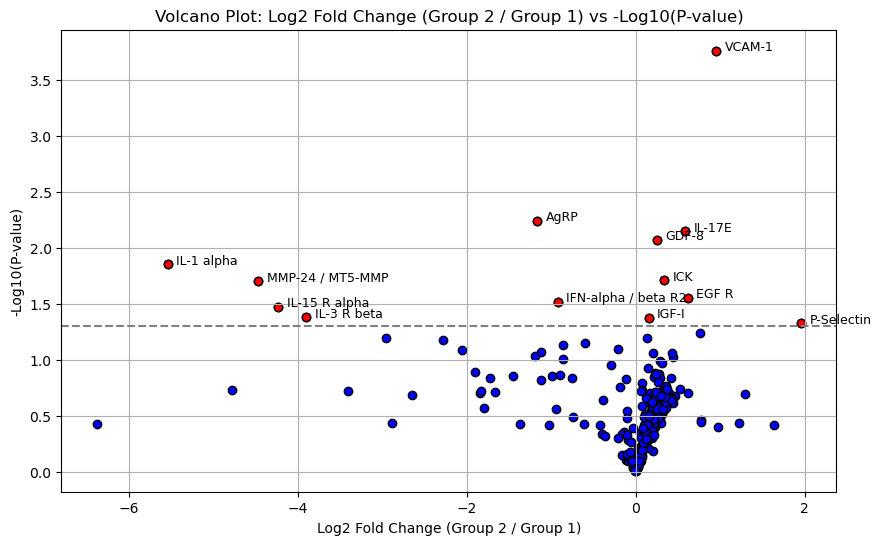

In [3]:
# Load the Excel sheet (replace 'your_file.xlsx' with your actual file name)
file_path = 'A5iOT_Serum BONCAT.xlsx'
df = pd.read_excel(file_path, header=None)

# Choose which comparison to run
#"Enter 'paired' for paired T-test or 'unpaired' for unpaired T-test: "
#Set eq_var to True for unpaired T-test if there is expected to be equal variance
comparison_type = 'unpaired'
eq_var = False
paired_g1_treat, paired_g1_age = 'E','B'
paired_g2_treat, paired_g2_age = 'E','A'
unpaired_g1_treat, unpaired_g1_age = 'C','A'
unpaired_g2_treat, unpaired_g2_age = 'E','A'

#comparison_type = comparison_type = input("Enter 'paired' for paired T-test or 'unpaired' for unpaired T-test: ").strip().lower()

# Process the input data
# First row: Sample IDs
sample_ids = df.iloc[0, 1:]

# Second row: Treatment
treatments = df.iloc[1, 1:]

# Third row: Age
ages = df.iloc[2, 1:]

# Protein names (1st column)
proteins = df.iloc[3:, 0]


# Protein expression data (everything from row 4 onward, excluding the first column)
expression_data = df.iloc[3:, 1:].T
expression_data.columns = proteins  # Set protein names as column headers

# Function to perform paired T-test (e.g., Age "B" & Treatment "E" vs Age "A" & Treatment "E")
def paired_t_test():
    # Filter for Group 1: Age = "B" and Treatment = "E"
    group1_mask = (treatments == paired_g1_treat) & (ages == paired_g1_age)
    group1_data = expression_data[group1_mask]

    # Filter for Group 2: Age = "A" and Treatment = "E"
    group2_mask = (treatments == paired_g2_treat) & (ages == paired_g2_age)
    group2_data = expression_data[group2_mask]

    # Ensure both groups have the same samples (IDs)
    group1_sample_ids = sample_ids[group1_mask]
    group2_sample_ids = sample_ids[group2_mask]

    # Match samples based on their IDs
    paired_samples = group1_sample_ids[group1_sample_ids.isin(group2_sample_ids)]

    # Extract data for the matched samples
    group1_matched = group1_data.loc[group1_sample_ids.isin(paired_samples)]
    group2_matched = group2_data.loc[group2_sample_ids.isin(paired_samples)]

    # Perform paired T-test on each protein
    p_values = []
    for protein in proteins:
        t_stat, p_val = ttest_rel(group1_matched[protein], group2_matched[protein])
        p_values.append((protein, p_val))

    # Convert the results into a DataFrame and filter for significant differences
    pval_df = pd.DataFrame(p_values, columns=['Protein', 'P-value'])
    significant_proteins = pval_df[pval_df['P-value'] < 0.05]

    # Print the proteins with significant differences and their p-values
    print("Paired T-test: Proteins with significant differences (P < 0.05):")
    print(significant_proteins)
    print(list(significant_proteins['Protein']))
    return pval_df

# Function to perform unpaired T-test (e.g., Age "A" & Treatment "E" vs Age "A" & Treatment "C")
def unpaired_t_test():
    # Filter for Group 1: Age = "A" and Treatment = "E"
    group1_mask = (treatments == unpaired_g1_treat) & (ages == unpaired_g1_age)
    group1_data = expression_data[group1_mask]

    # Filter for Group 2: Age = "A" and Treatment = "C"
    group2_mask = (treatments == unpaired_g2_treat) & (ages == unpaired_g2_age)
    group2_data = expression_data[group2_mask]

    # Perform unpaired T-test on each protein
    p_values = []
    for protein in proteins:
        t_stat, p_val = ttest_ind(list(group1_data[protein]), list(group2_data[protein]),equal_var=eq_var)
        p_values.append((protein, p_val))

    # Convert the results into a DataFrame and filter for significant differences
    pval_df = pd.DataFrame(p_values, columns=['Protein', 'P-value'])
    significant_proteins = pval_df[pval_df['P-value'] < 0.05]

    # Print the proteins with significant differences and their p-values
    print("Unpaired T-test: Proteins with significant differences (P < 0.05):")
    print(significant_proteins)
    print(list(significant_proteins['Protein']))
    return pval_df

if comparison_type == 'paired':
    pval_df = paired_t_test()
elif comparison_type == 'unpaired':
    pval_df = unpaired_t_test()
else:
    print("Invalid input. Please enter either 'paired' or 'unpaired'.")

#Volcano Plot Below
#Define group masks (replace with actual conditions from the dataset when using real data)

if comparison_type == 'unpaired':
    group1_mask = (treatments == unpaired_g1_treat) & (ages == unpaired_g1_age)  # Group 1: unpaired_g1_treat & unpaired_g1_age
    group2_mask = (treatments == unpaired_g2_treat) & (ages == unpaired_g2_age)  # Group 2: unpaired_g2_treat & unpaired_g2_age

elif comparison_type == 'paired':
    group1_mask = (treatments == paired_g1_treat) & (ages == paired_g1_age)
    group2_mask = (treatments == paired_g2_treat) & (ages == paired_g2_age)

# Filter the expression data for each group
group1_data = expression_data[group1_mask]
group2_data = expression_data[group2_mask]

# Calculate the average fold change for each protein as the log2(Group 2 mean / Group 1 mean)
fold_changes = np.log2(group2_data.mean() / group1_data.mean())

# Prepare the volcano plot
pval_df['Log2 Fold Change'] = fold_changes.values
pval_df['-log10(P-value)'] = -np.log10(pval_df['P-value'])

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(pval_df['Log2 Fold Change'], pval_df['-log10(P-value)'], color='blue', edgecolor='black')

# Highlight significant proteins (p-value < 0.05)
significant_proteins = pval_df[pval_df['P-value'] < 0.05]
plt.scatter(significant_proteins['Log2 Fold Change'], significant_proteins['-log10(P-value)'], color='red', edgecolor='black')

# Add labels for significant proteins
for i, row in significant_proteins.iterrows():
    plt.text(row['Log2 Fold Change'] + 0.1, row['-log10(P-value)'], row['Protein'], fontsize=9, color='black')

# Label plot
plt.title('Volcano Plot: Log2 Fold Change (Group 2 / Group 1) vs -Log10(P-value)')
plt.xlabel('Log2 Fold Change (Group 2 / Group 1)')
plt.ylabel('-Log10(P-value)')
plt.axhline(y=-np.log10(0.05), color='grey', linestyle='--')
plt.grid(True)

# Show plot
plt.show()


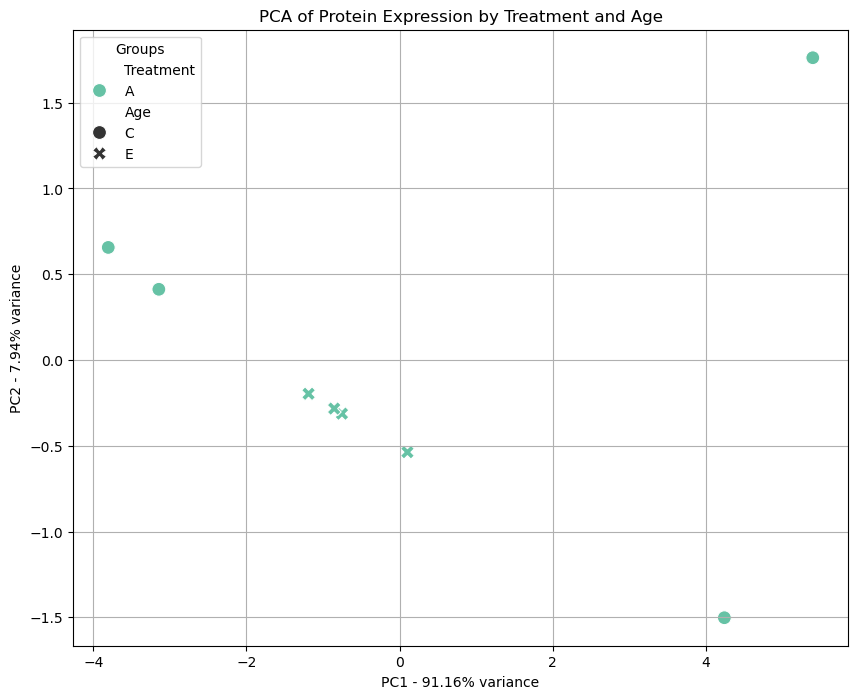

In [5]:
# Load the Excel sheet (make sure to replace 'your_file.xlsx' with your actual file name)
file_path = 'A5iOT_Serum BONCAT.xlsx'
df = pd.read_excel(file_path, header=None)

# Process the input data
# First row: Sample IDs
sample_ids = df.iloc[0, 1:]

# Second row: Treatment
treatments = df.iloc[1, 1:]

# Third row: Age
ages = df.iloc[2, 1:]

# Protein names (1st column)
proteins = df.iloc[3:, 0]

# Protein expression data (everything from row 4 onward, excluding the first column)
expression_data = df.iloc[3:, 1:].T
expression_data.columns = proteins  # Set protein names as column headers

# Perform PCA on the expression data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(expression_data)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Treatment'] = treatments.values
pca_df['Age'] = ages.values
pca_df['SampleID'] = sample_ids.values

# Plot PCA result
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Treatment', style='Age', data=pca_df, s=100, palette='Set2')
plt.title('PCA of Protein Expression by Treatment and Age')
plt.xlabel(f'PC1 - {pca.explained_variance_ratio_[0]:.2%} variance')
plt.ylabel(f'PC2 - {pca.explained_variance_ratio_[1]:.2%} variance')
plt.legend(loc='best', title='Groups')
plt.grid(True)
plt.show()
